# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

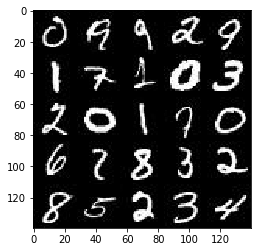

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

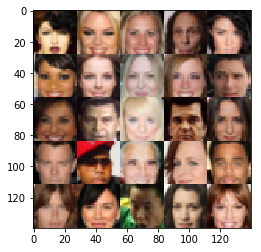

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_inputs = tf.placeholder(tf.float32, [None, image_width, image_height, image_channels], name='input_images')
    z_inputs = tf.placeholder(tf.float32, [None, z_dim], name='z_input')
    learning_rate = tf.placeholder(tf.float32, shape=(), name='learning_rate')
    
    return (real_inputs, z_inputs, learning_rate)

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [6]:
def discriminator(images, reuse=False, alpha=0.2):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # The discriminator network is a regular convolutional network which takes in the real and fake images as input
    with tf.variable_scope('discriminator', reuse=reuse):
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='SAME')
        leaky_relu1 = tf.maximum(alpha*x1, x1)
        
        x2 = tf.layers.conv2d(leaky_relu1, 128, 5, strides=2, padding='SAME')
        batch_norm2 = tf.layers.batch_normalization(x2, training=True)
        leaky_relu2 = tf.maximum(alpha*batch_norm2, batch_norm2)

        x3 = tf.layers.conv2d(leaky_relu2, 256, 5, strides=1, padding='SAME')
        batch_norm3 = tf.layers.batch_normalization(x3, training=True)
        leaky_relu3 = tf.maximum(alpha*batch_norm3, batch_norm3)
        
        x4 = tf.layers.conv2d(leaky_relu3, 512, 5, strides=1, padding='SAME')
        batch_norm4 = tf.layers.batch_normalization(x4, training=True)
        leaky_relu4 = tf.maximum(alpha*batch_norm4, batch_norm4)

        # Now after the convolution layers we have to flatten the tensor and feed it into a fully-connected layer
        flattened_tensor = tf.reshape(leaky_relu4,(-1,7*7*512))
        logits = tf.layers.dense(flattened_tensor, 1)
        output = tf.sigmoid(logits) 
    return (output, logits)

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True, alpha=0.25):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # The generator network works similar to a deconvolution network
    '''
    Reuse refers to when the variables of the generator will be used again. We want to first train the generator
    and then use it's trained variables to generate new images. So the is_train variable is used to monitor whether 
    the generator network is training or not, so that we can accordingly change reuse to the negative of training 
    mode to reuse variables when it is done training.
    '''
    with tf.variable_scope('generator', reuse= not is_train):
        ''' 
        For this network we will send the latent noise vector through a fully connected layer and then 
        reshape it into a deep convolutional stack layer
        '''
        x1 = tf.layers.dense(z, 7*7*512)
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.maximum(alpha*x1, x1)
        
        # Now for the transpose convolutions..
        x2 = tf.layers.conv2d_transpose(x1, 256, 3, strides=1, padding='SAME')
        x2 = tf.layers.batch_normalization(x2, training=True)
        x2 = tf.maximum(alpha*x2, x2)
    
        x3 = tf.layers.conv2d_transpose(x2, 128, 3, strides=1, padding='SAME')
        x3 = tf.layers.batch_normalization(x3, training=True)
        x3 = tf.maximum(alpha*x3, x3)

        x4 = tf.layers.conv2d_transpose(x3, 64, 3, strides=2, padding='SAME')
        x4 = tf.layers.batch_normalization(x4, training=True)
        x4 = tf.maximum(alpha*x4, x4)

        logits = tf.layers.conv2d_transpose(x4, out_channel_dim, 3, strides=2, padding='SAME')
        output = tf.tanh(logits)
        return output
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    generator_model = generator(input_z, out_channel_dim, is_train=True)
    disc_model_real, disc_logits_real = discriminator(input_real, reuse=False)
    disc_model_fake, disc_logits_fake = discriminator(generator_model, reuse=True)
    
    gen_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=disc_logits_fake, 
                                        labels=tf.ones_like(disc_model_fake)))
    
    disc_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=disc_logits_real, 
                                        labels=tf.ones_like(disc_model_real)))
    
    disc_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=disc_logits_fake, 
                                        labels=tf.zeros_like(disc_model_fake)))
    
    total_disc_loss = disc_loss_real + disc_loss_fake
    
    return (total_disc_loss, gen_loss)
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    trainable_vars = tf.trainable_variables()
    discriminator_vars = [var for var in trainable_vars if var.name.startswith('discriminator')]
    generator_vars = [var for var in trainable_vars if var.name.startswith('generator')]
    
    disc_optimizer = tf.train.AdamOptimizer(learning_rate, beta1).minimize(d_loss, var_list=discriminator_vars)
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    g_updates = [opt for opt in update_ops if opt.name.startswith('generator')]
    with tf.control_dependencies(g_updates):
        gen_optimizer = tf.train.AdamOptimizer(learning_rate, beta1).minimize(g_loss, var_list=generator_vars)
    
    return (disc_optimizer, gen_optimizer)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    input_real, input_z, lr_ph = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    disc_loss, gen_loss = model_loss(input_real, input_z, data_shape[3])
    disc_optimizer, gen_optimizer = model_opt(disc_loss, gen_loss, lr_ph, beta1)
    batch_count = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                batch_images = batch_images*2
                batch_count += 1
                # Random noise for each batch
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                # Running optimizers
                _ = sess.run(disc_optimizer, feed_dict={input_real:batch_images, input_z:batch_z, lr_ph:learning_rate})
                _ = sess.run(gen_optimizer, feed_dict={input_z: batch_z, lr_ph:learning_rate})
                

                # Evaluating the results                
                if batch_count % 10 == 0:
                    train_loss_d = disc_loss.eval({input_real: batch_images, input_z:batch_z, lr_ph: learning_rate})
                    train_loss_g = gen_loss.eval({input_z: batch_z, lr_ph:learning_rate})
                    
                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                if batch_count % 100 == 0:
                    show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 10.4656... Generator Loss: 0.0002
Epoch 1/2... Discriminator Loss: 0.4409... Generator Loss: 24.9769
Epoch 1/2... Discriminator Loss: 9.1019... Generator Loss: 0.0054
Epoch 1/2... Discriminator Loss: 4.6865... Generator Loss: 1.7877
Epoch 1/2... Discriminator Loss: 2.2476... Generator Loss: 10.8960
Epoch 1/2... Discriminator Loss: 3.8810... Generator Loss: 0.3217
Epoch 1/2... Discriminator Loss: 6.2321... Generator Loss: 12.5674
Epoch 1/2... Discriminator Loss: 2.1844... Generator Loss: 2.9944
Epoch 1/2... Discriminator Loss: 9.5371... Generator Loss: 16.5287
Epoch 1/2... Discriminator Loss: 4.1885... Generator Loss: 0.1042


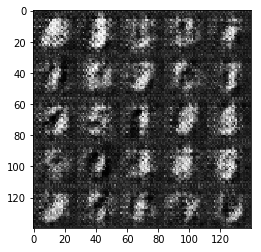

Epoch 1/2... Discriminator Loss: 1.5713... Generator Loss: 1.5072
Epoch 1/2... Discriminator Loss: 1.7689... Generator Loss: 4.3356
Epoch 1/2... Discriminator Loss: 2.7375... Generator Loss: 0.4798
Epoch 1/2... Discriminator Loss: 5.4315... Generator Loss: 0.0089
Epoch 1/2... Discriminator Loss: 0.8172... Generator Loss: 3.2297
Epoch 1/2... Discriminator Loss: 0.1937... Generator Loss: 4.9006
Epoch 1/2... Discriminator Loss: 0.7615... Generator Loss: 1.0445
Epoch 1/2... Discriminator Loss: 1.9573... Generator Loss: 2.3705
Epoch 1/2... Discriminator Loss: 1.5883... Generator Loss: 2.0661
Epoch 1/2... Discriminator Loss: 0.4964... Generator Loss: 2.5327


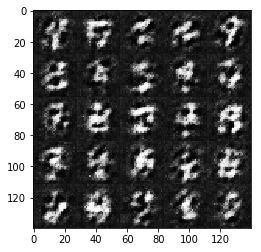

Epoch 1/2... Discriminator Loss: 3.7305... Generator Loss: 0.1833
Epoch 1/2... Discriminator Loss: 1.3025... Generator Loss: 2.3379
Epoch 1/2... Discriminator Loss: 0.1847... Generator Loss: 4.7781
Epoch 1/2... Discriminator Loss: 0.0697... Generator Loss: 4.0850
Epoch 1/2... Discriminator Loss: 0.5147... Generator Loss: 2.3539
Epoch 1/2... Discriminator Loss: 0.5962... Generator Loss: 2.1263
Epoch 1/2... Discriminator Loss: 0.7731... Generator Loss: 1.2339
Epoch 1/2... Discriminator Loss: 0.3646... Generator Loss: 4.0651
Epoch 1/2... Discriminator Loss: 0.1489... Generator Loss: 3.0469
Epoch 1/2... Discriminator Loss: 1.4599... Generator Loss: 0.5686


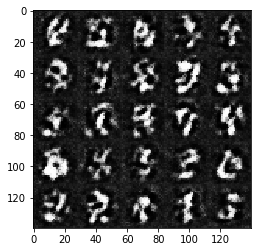

Epoch 1/2... Discriminator Loss: 0.1569... Generator Loss: 2.5365
Epoch 1/2... Discriminator Loss: 11.8808... Generator Loss: 12.3552
Epoch 1/2... Discriminator Loss: 0.9307... Generator Loss: 1.8514
Epoch 1/2... Discriminator Loss: 1.5791... Generator Loss: 0.5794
Epoch 1/2... Discriminator Loss: 3.1049... Generator Loss: 0.1914
Epoch 1/2... Discriminator Loss: 0.7893... Generator Loss: 1.8992
Epoch 1/2... Discriminator Loss: 0.3426... Generator Loss: 1.5891
Epoch 1/2... Discriminator Loss: 0.1669... Generator Loss: 3.2394
Epoch 1/2... Discriminator Loss: 3.4449... Generator Loss: 0.0866
Epoch 1/2... Discriminator Loss: 0.7406... Generator Loss: 1.0651


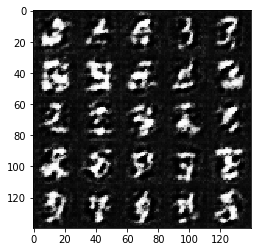

Epoch 1/2... Discriminator Loss: 0.5241... Generator Loss: 3.2902
Epoch 1/2... Discriminator Loss: 4.7910... Generator Loss: 0.0241
Epoch 1/2... Discriminator Loss: 1.6824... Generator Loss: 0.6019
Epoch 1/2... Discriminator Loss: 0.1519... Generator Loss: 2.8740
Epoch 1/2... Discriminator Loss: 0.6786... Generator Loss: 1.0961
Epoch 1/2... Discriminator Loss: 0.1652... Generator Loss: 4.8263
Epoch 1/2... Discriminator Loss: 0.4703... Generator Loss: 1.3766
Epoch 1/2... Discriminator Loss: 0.3181... Generator Loss: 1.7494
Epoch 1/2... Discriminator Loss: 0.4260... Generator Loss: 4.0992
Epoch 1/2... Discriminator Loss: 0.9458... Generator Loss: 1.0481


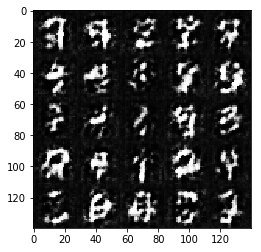

Epoch 1/2... Discriminator Loss: 0.6807... Generator Loss: 1.1288
Epoch 1/2... Discriminator Loss: 0.2045... Generator Loss: 2.5905
Epoch 1/2... Discriminator Loss: 2.0732... Generator Loss: 0.3141
Epoch 1/2... Discriminator Loss: 0.7753... Generator Loss: 1.3186
Epoch 1/2... Discriminator Loss: 0.5711... Generator Loss: 1.2378
Epoch 1/2... Discriminator Loss: 1.1070... Generator Loss: 0.8125
Epoch 1/2... Discriminator Loss: 0.7758... Generator Loss: 3.1968
Epoch 1/2... Discriminator Loss: 3.4847... Generator Loss: 0.2981
Epoch 1/2... Discriminator Loss: 1.8500... Generator Loss: 0.3024
Epoch 1/2... Discriminator Loss: 0.7710... Generator Loss: 1.2277


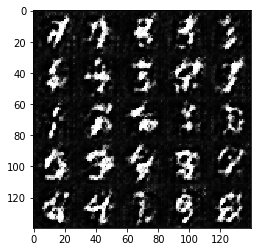

Epoch 1/2... Discriminator Loss: 3.8042... Generator Loss: 0.0551
Epoch 1/2... Discriminator Loss: 1.0615... Generator Loss: 1.0006
Epoch 1/2... Discriminator Loss: 0.1824... Generator Loss: 2.7329
Epoch 1/2... Discriminator Loss: 0.6676... Generator Loss: 1.3555
Epoch 1/2... Discriminator Loss: 0.4977... Generator Loss: 1.6012
Epoch 1/2... Discriminator Loss: 2.3245... Generator Loss: 0.2353
Epoch 1/2... Discriminator Loss: 1.9200... Generator Loss: 0.2080
Epoch 1/2... Discriminator Loss: 1.7400... Generator Loss: 0.4531
Epoch 1/2... Discriminator Loss: 3.0761... Generator Loss: 0.1301
Epoch 1/2... Discriminator Loss: 2.2197... Generator Loss: 0.7848


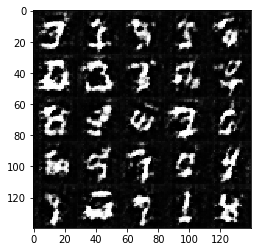

Epoch 1/2... Discriminator Loss: 0.7291... Generator Loss: 1.1159
Epoch 1/2... Discriminator Loss: 0.2658... Generator Loss: 2.3541
Epoch 1/2... Discriminator Loss: 1.1574... Generator Loss: 1.0522
Epoch 1/2... Discriminator Loss: 0.7976... Generator Loss: 0.9518
Epoch 1/2... Discriminator Loss: 0.7092... Generator Loss: 1.1139
Epoch 1/2... Discriminator Loss: 0.4177... Generator Loss: 1.5921
Epoch 1/2... Discriminator Loss: 0.0686... Generator Loss: 3.8916
Epoch 1/2... Discriminator Loss: 0.5471... Generator Loss: 1.6071
Epoch 1/2... Discriminator Loss: 2.8466... Generator Loss: 12.2588
Epoch 1/2... Discriminator Loss: 0.7992... Generator Loss: 1.2664


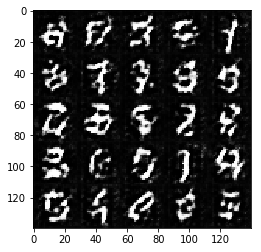

Epoch 1/2... Discriminator Loss: 1.3713... Generator Loss: 0.6348
Epoch 1/2... Discriminator Loss: 1.2834... Generator Loss: 3.5729
Epoch 1/2... Discriminator Loss: 0.8097... Generator Loss: 3.8368
Epoch 1/2... Discriminator Loss: 0.1058... Generator Loss: 3.8161
Epoch 1/2... Discriminator Loss: 1.3123... Generator Loss: 0.8209
Epoch 1/2... Discriminator Loss: 1.6981... Generator Loss: 0.6362
Epoch 1/2... Discriminator Loss: 1.8316... Generator Loss: 4.8593
Epoch 1/2... Discriminator Loss: 2.8845... Generator Loss: 0.1310
Epoch 1/2... Discriminator Loss: 0.5408... Generator Loss: 1.3164
Epoch 1/2... Discriminator Loss: 2.5172... Generator Loss: 0.2892


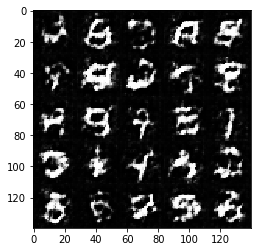

Epoch 1/2... Discriminator Loss: 0.4748... Generator Loss: 2.0013
Epoch 1/2... Discriminator Loss: 0.9939... Generator Loss: 0.8330
Epoch 1/2... Discriminator Loss: 1.3570... Generator Loss: 6.0459
Epoch 1/2... Discriminator Loss: 0.4331... Generator Loss: 3.1060
Epoch 1/2... Discriminator Loss: 1.5239... Generator Loss: 0.4591
Epoch 1/2... Discriminator Loss: 1.6542... Generator Loss: 0.3085
Epoch 1/2... Discriminator Loss: 0.3987... Generator Loss: 3.4055
Epoch 1/2... Discriminator Loss: 1.1104... Generator Loss: 0.7034
Epoch 1/2... Discriminator Loss: 0.4497... Generator Loss: 1.2831
Epoch 1/2... Discriminator Loss: 2.3922... Generator Loss: 0.2091


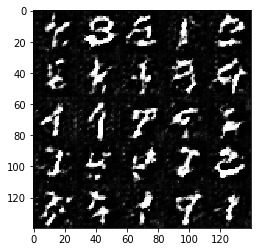

Epoch 1/2... Discriminator Loss: 0.4111... Generator Loss: 1.6562
Epoch 1/2... Discriminator Loss: 0.6644... Generator Loss: 3.0939
Epoch 1/2... Discriminator Loss: 1.9230... Generator Loss: 0.2013
Epoch 1/2... Discriminator Loss: 0.3162... Generator Loss: 2.0553
Epoch 1/2... Discriminator Loss: 1.2675... Generator Loss: 0.5172
Epoch 1/2... Discriminator Loss: 0.3614... Generator Loss: 1.4434
Epoch 1/2... Discriminator Loss: 1.0011... Generator Loss: 0.9145
Epoch 1/2... Discriminator Loss: 0.2954... Generator Loss: 3.5941
Epoch 1/2... Discriminator Loss: 0.3079... Generator Loss: 1.8981
Epoch 1/2... Discriminator Loss: 2.2065... Generator Loss: 0.5394


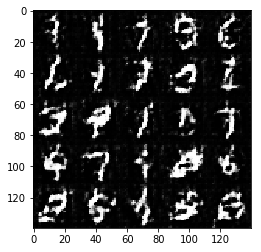

Epoch 1/2... Discriminator Loss: 0.5073... Generator Loss: 2.1853
Epoch 1/2... Discriminator Loss: 3.1216... Generator Loss: 0.0810
Epoch 1/2... Discriminator Loss: 0.6952... Generator Loss: 4.5725
Epoch 1/2... Discriminator Loss: 3.8550... Generator Loss: 0.0688
Epoch 1/2... Discriminator Loss: 0.3770... Generator Loss: 2.9297
Epoch 1/2... Discriminator Loss: 1.4109... Generator Loss: 0.6218
Epoch 1/2... Discriminator Loss: 0.6773... Generator Loss: 1.2715
Epoch 1/2... Discriminator Loss: 0.3116... Generator Loss: 3.8496
Epoch 1/2... Discriminator Loss: 0.6523... Generator Loss: 1.5983
Epoch 1/2... Discriminator Loss: 0.1855... Generator Loss: 2.4026


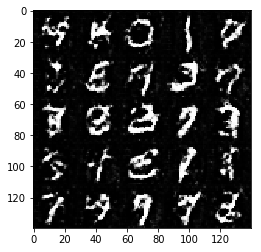

Epoch 1/2... Discriminator Loss: 0.4485... Generator Loss: 1.4754
Epoch 1/2... Discriminator Loss: 0.4498... Generator Loss: 1.5609
Epoch 1/2... Discriminator Loss: 1.7265... Generator Loss: 0.3449
Epoch 1/2... Discriminator Loss: 2.0837... Generator Loss: 0.5679
Epoch 1/2... Discriminator Loss: 0.6852... Generator Loss: 2.4492
Epoch 1/2... Discriminator Loss: 2.2925... Generator Loss: 0.3888
Epoch 1/2... Discriminator Loss: 1.1108... Generator Loss: 0.8911
Epoch 1/2... Discriminator Loss: 1.3550... Generator Loss: 0.5597
Epoch 1/2... Discriminator Loss: 1.1520... Generator Loss: 0.5382
Epoch 1/2... Discriminator Loss: 0.9466... Generator Loss: 0.6692


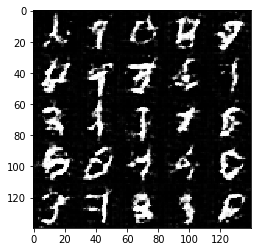

Epoch 1/2... Discriminator Loss: 0.1744... Generator Loss: 2.2621
Epoch 1/2... Discriminator Loss: 0.3809... Generator Loss: 2.0897
Epoch 1/2... Discriminator Loss: 0.1511... Generator Loss: 2.8840
Epoch 1/2... Discriminator Loss: 0.8890... Generator Loss: 0.8378
Epoch 1/2... Discriminator Loss: 2.1100... Generator Loss: 0.3374
Epoch 1/2... Discriminator Loss: 1.3217... Generator Loss: 0.4166
Epoch 1/2... Discriminator Loss: 0.1325... Generator Loss: 3.7165
Epoch 1/2... Discriminator Loss: 1.6765... Generator Loss: 0.9443
Epoch 1/2... Discriminator Loss: 1.0818... Generator Loss: 0.8509
Epoch 1/2... Discriminator Loss: 0.6283... Generator Loss: 1.2195


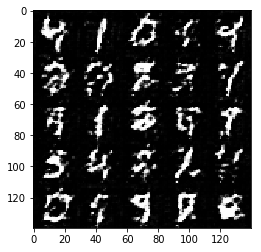

Epoch 1/2... Discriminator Loss: 3.2352... Generator Loss: 0.1195
Epoch 1/2... Discriminator Loss: 2.2104... Generator Loss: 0.2317
Epoch 1/2... Discriminator Loss: 4.5215... Generator Loss: 0.0450
Epoch 1/2... Discriminator Loss: 6.0662... Generator Loss: 0.0103
Epoch 1/2... Discriminator Loss: 2.5287... Generator Loss: 0.1614
Epoch 1/2... Discriminator Loss: 1.6677... Generator Loss: 1.9033
Epoch 1/2... Discriminator Loss: 1.5237... Generator Loss: 2.4618
Epoch 1/2... Discriminator Loss: 1.5197... Generator Loss: 5.2282
Epoch 1/2... Discriminator Loss: 1.7880... Generator Loss: 0.5268
Epoch 1/2... Discriminator Loss: 0.4541... Generator Loss: 1.9706


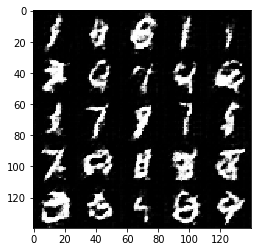

Epoch 1/2... Discriminator Loss: 0.4789... Generator Loss: 1.2545
Epoch 1/2... Discriminator Loss: 0.3345... Generator Loss: 2.0277
Epoch 1/2... Discriminator Loss: 3.7572... Generator Loss: 0.0364
Epoch 1/2... Discriminator Loss: 0.9855... Generator Loss: 2.8097
Epoch 1/2... Discriminator Loss: 5.6895... Generator Loss: 0.0052
Epoch 1/2... Discriminator Loss: 0.7927... Generator Loss: 1.0428
Epoch 1/2... Discriminator Loss: 3.7674... Generator Loss: 0.0440
Epoch 1/2... Discriminator Loss: 0.4477... Generator Loss: 1.2976
Epoch 1/2... Discriminator Loss: 1.4309... Generator Loss: 0.3362
Epoch 1/2... Discriminator Loss: 1.4029... Generator Loss: 1.0139


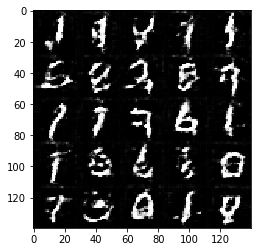

Epoch 1/2... Discriminator Loss: 1.8855... Generator Loss: 0.2675
Epoch 1/2... Discriminator Loss: 0.8790... Generator Loss: 1.6289
Epoch 1/2... Discriminator Loss: 1.0320... Generator Loss: 0.7196
Epoch 1/2... Discriminator Loss: 2.1841... Generator Loss: 0.1742
Epoch 1/2... Discriminator Loss: 3.9260... Generator Loss: 0.0305
Epoch 1/2... Discriminator Loss: 2.4244... Generator Loss: 0.1344
Epoch 1/2... Discriminator Loss: 2.3504... Generator Loss: 8.7337
Epoch 1/2... Discriminator Loss: 5.1501... Generator Loss: 0.0128
Epoch 1/2... Discriminator Loss: 0.8402... Generator Loss: 1.6664
Epoch 1/2... Discriminator Loss: 2.1170... Generator Loss: 0.3601


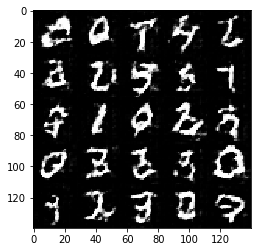

Epoch 1/2... Discriminator Loss: 2.5108... Generator Loss: 0.1619
Epoch 1/2... Discriminator Loss: 1.1643... Generator Loss: 0.6334
Epoch 1/2... Discriminator Loss: 0.7926... Generator Loss: 0.9480
Epoch 1/2... Discriminator Loss: 4.7502... Generator Loss: 0.0155
Epoch 1/2... Discriminator Loss: 1.0930... Generator Loss: 1.0298
Epoch 1/2... Discriminator Loss: 1.3118... Generator Loss: 0.8491
Epoch 1/2... Discriminator Loss: 1.0193... Generator Loss: 5.7051
Epoch 1/2... Discriminator Loss: 3.9799... Generator Loss: 0.1048
Epoch 1/2... Discriminator Loss: 0.4742... Generator Loss: 1.4426
Epoch 1/2... Discriminator Loss: 1.2676... Generator Loss: 0.8449


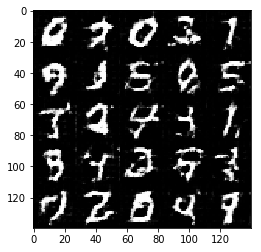

Epoch 1/2... Discriminator Loss: 2.1564... Generator Loss: 0.5302
Epoch 1/2... Discriminator Loss: 1.5401... Generator Loss: 0.5778
Epoch 1/2... Discriminator Loss: 3.9777... Generator Loss: 0.0326
Epoch 1/2... Discriminator Loss: 1.5149... Generator Loss: 0.5235
Epoch 1/2... Discriminator Loss: 0.4304... Generator Loss: 2.9175
Epoch 1/2... Discriminator Loss: 2.3562... Generator Loss: 0.4741
Epoch 1/2... Discriminator Loss: 0.4193... Generator Loss: 1.7527
Epoch 1/2... Discriminator Loss: 0.7050... Generator Loss: 1.0291
Epoch 1/2... Discriminator Loss: 2.0441... Generator Loss: 0.2842
Epoch 1/2... Discriminator Loss: 0.5131... Generator Loss: 1.0926


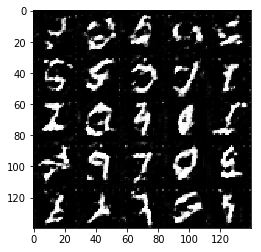

Epoch 1/2... Discriminator Loss: 2.9537... Generator Loss: 0.1928
Epoch 1/2... Discriminator Loss: 1.7936... Generator Loss: 0.3404
Epoch 1/2... Discriminator Loss: 2.6292... Generator Loss: 11.4004
Epoch 1/2... Discriminator Loss: 0.7965... Generator Loss: 0.9929
Epoch 1/2... Discriminator Loss: 0.7162... Generator Loss: 1.6956
Epoch 1/2... Discriminator Loss: 1.2740... Generator Loss: 1.1212
Epoch 1/2... Discriminator Loss: 3.5786... Generator Loss: 0.1096
Epoch 1/2... Discriminator Loss: 1.6492... Generator Loss: 0.5110
Epoch 1/2... Discriminator Loss: 0.4346... Generator Loss: 1.9172
Epoch 1/2... Discriminator Loss: 0.9202... Generator Loss: 2.0626


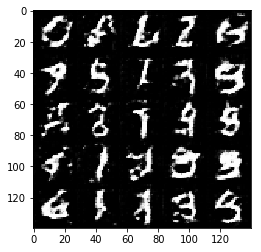

Epoch 1/2... Discriminator Loss: 1.8492... Generator Loss: 0.8176
Epoch 1/2... Discriminator Loss: 3.4317... Generator Loss: 0.2086
Epoch 1/2... Discriminator Loss: 1.7869... Generator Loss: 0.5156
Epoch 1/2... Discriminator Loss: 0.3179... Generator Loss: 2.0853
Epoch 1/2... Discriminator Loss: 3.3430... Generator Loss: 0.1128
Epoch 1/2... Discriminator Loss: 0.4125... Generator Loss: 1.6693
Epoch 1/2... Discriminator Loss: 2.4711... Generator Loss: 0.5242
Epoch 1/2... Discriminator Loss: 0.8802... Generator Loss: 0.7494
Epoch 1/2... Discriminator Loss: 0.9921... Generator Loss: 0.6621
Epoch 1/2... Discriminator Loss: 1.3233... Generator Loss: 0.8290


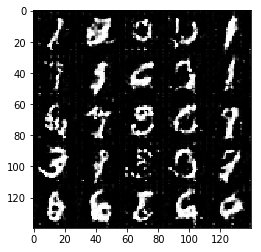

Epoch 1/2... Discriminator Loss: 2.0353... Generator Loss: 0.4051
Epoch 1/2... Discriminator Loss: 3.5113... Generator Loss: 0.0444
Epoch 1/2... Discriminator Loss: 4.2703... Generator Loss: 0.0290
Epoch 1/2... Discriminator Loss: 2.9488... Generator Loss: 0.1212
Epoch 1/2... Discriminator Loss: 1.7045... Generator Loss: 1.2685
Epoch 1/2... Discriminator Loss: 0.3510... Generator Loss: 2.6372
Epoch 1/2... Discriminator Loss: 1.3722... Generator Loss: 0.5431
Epoch 1/2... Discriminator Loss: 0.9659... Generator Loss: 2.3735
Epoch 1/2... Discriminator Loss: 0.3526... Generator Loss: 2.5646
Epoch 1/2... Discriminator Loss: 0.4351... Generator Loss: 1.6643


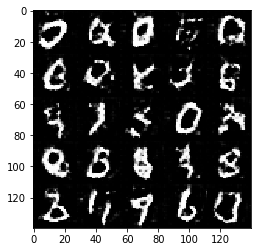

Epoch 1/2... Discriminator Loss: 1.7358... Generator Loss: 0.4825
Epoch 1/2... Discriminator Loss: 1.2715... Generator Loss: 0.8012
Epoch 1/2... Discriminator Loss: 0.1212... Generator Loss: 4.4931
Epoch 1/2... Discriminator Loss: 0.0990... Generator Loss: 3.7388
Epoch 1/2... Discriminator Loss: 4.7211... Generator Loss: 0.0357
Epoch 1/2... Discriminator Loss: 2.0195... Generator Loss: 0.4152
Epoch 1/2... Discriminator Loss: 0.8486... Generator Loss: 0.8511
Epoch 1/2... Discriminator Loss: 0.4975... Generator Loss: 1.8538
Epoch 1/2... Discriminator Loss: 1.4268... Generator Loss: 0.4837
Epoch 1/2... Discriminator Loss: 1.8484... Generator Loss: 0.2980


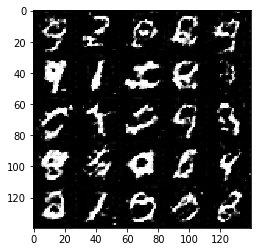

Epoch 1/2... Discriminator Loss: 0.5503... Generator Loss: 1.4689
Epoch 1/2... Discriminator Loss: 1.7088... Generator Loss: 0.2822
Epoch 1/2... Discriminator Loss: 1.2404... Generator Loss: 0.5853
Epoch 1/2... Discriminator Loss: 0.9567... Generator Loss: 0.9342
Epoch 1/2... Discriminator Loss: 0.4774... Generator Loss: 2.0495
Epoch 1/2... Discriminator Loss: 0.5270... Generator Loss: 1.2882
Epoch 1/2... Discriminator Loss: 0.3940... Generator Loss: 5.2764
Epoch 1/2... Discriminator Loss: 0.7756... Generator Loss: 4.9761
Epoch 1/2... Discriminator Loss: 1.2471... Generator Loss: 1.1076
Epoch 1/2... Discriminator Loss: 1.1582... Generator Loss: 1.0287


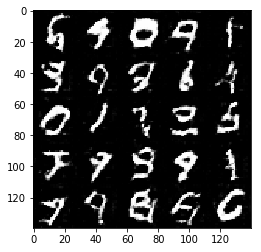

Epoch 1/2... Discriminator Loss: 1.8808... Generator Loss: 0.3246
Epoch 1/2... Discriminator Loss: 0.4853... Generator Loss: 2.5510
Epoch 1/2... Discriminator Loss: 0.3937... Generator Loss: 5.1741
Epoch 1/2... Discriminator Loss: 2.1942... Generator Loss: 0.2664
Epoch 1/2... Discriminator Loss: 0.4685... Generator Loss: 1.5615
Epoch 1/2... Discriminator Loss: 2.5467... Generator Loss: 0.2744
Epoch 1/2... Discriminator Loss: 4.6512... Generator Loss: 0.0151
Epoch 1/2... Discriminator Loss: 1.9805... Generator Loss: 0.2450
Epoch 1/2... Discriminator Loss: 2.8448... Generator Loss: 6.4283
Epoch 1/2... Discriminator Loss: 5.1910... Generator Loss: 0.0621


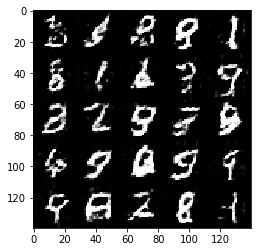

Epoch 1/2... Discriminator Loss: 1.3329... Generator Loss: 0.4337
Epoch 1/2... Discriminator Loss: 1.5919... Generator Loss: 0.3916
Epoch 1/2... Discriminator Loss: 1.6765... Generator Loss: 0.3884
Epoch 1/2... Discriminator Loss: 2.9866... Generator Loss: 0.2234
Epoch 1/2... Discriminator Loss: 0.8399... Generator Loss: 6.3256
Epoch 1/2... Discriminator Loss: 0.6817... Generator Loss: 1.6753
Epoch 1/2... Discriminator Loss: 5.1392... Generator Loss: 0.0128
Epoch 1/2... Discriminator Loss: 0.9867... Generator Loss: 1.5677
Epoch 1/2... Discriminator Loss: 0.9385... Generator Loss: 5.8853
Epoch 1/2... Discriminator Loss: 0.6995... Generator Loss: 1.2253


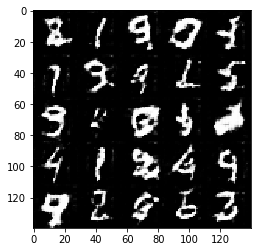

Epoch 1/2... Discriminator Loss: 2.5084... Generator Loss: 0.3072
Epoch 1/2... Discriminator Loss: 0.4104... Generator Loss: 3.0254
Epoch 1/2... Discriminator Loss: 1.9779... Generator Loss: 0.3541
Epoch 1/2... Discriminator Loss: 2.7623... Generator Loss: 0.1097
Epoch 1/2... Discriminator Loss: 1.3149... Generator Loss: 0.5236
Epoch 1/2... Discriminator Loss: 1.3591... Generator Loss: 0.4793
Epoch 1/2... Discriminator Loss: 1.3425... Generator Loss: 0.5219
Epoch 1/2... Discriminator Loss: 0.6821... Generator Loss: 1.1090
Epoch 1/2... Discriminator Loss: 2.2556... Generator Loss: 0.4327
Epoch 1/2... Discriminator Loss: 2.0198... Generator Loss: 0.2793


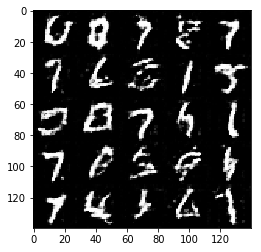

Epoch 1/2... Discriminator Loss: 1.0872... Generator Loss: 0.8020
Epoch 1/2... Discriminator Loss: 1.1620... Generator Loss: 0.6768
Epoch 1/2... Discriminator Loss: 2.7010... Generator Loss: 10.3210
Epoch 1/2... Discriminator Loss: 0.6260... Generator Loss: 1.7202
Epoch 1/2... Discriminator Loss: 0.2243... Generator Loss: 3.0700
Epoch 1/2... Discriminator Loss: 1.4035... Generator Loss: 1.1916
Epoch 1/2... Discriminator Loss: 3.2113... Generator Loss: 0.0990
Epoch 1/2... Discriminator Loss: 3.5864... Generator Loss: 0.3431
Epoch 1/2... Discriminator Loss: 1.9964... Generator Loss: 0.8247
Epoch 1/2... Discriminator Loss: 2.2482... Generator Loss: 0.2285


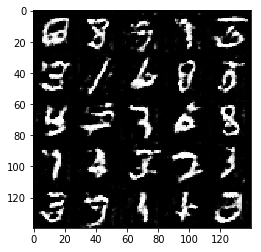

Epoch 1/2... Discriminator Loss: 2.3424... Generator Loss: 0.2750
Epoch 1/2... Discriminator Loss: 3.7400... Generator Loss: 0.0654
Epoch 1/2... Discriminator Loss: 0.3592... Generator Loss: 1.6379
Epoch 1/2... Discriminator Loss: 1.8809... Generator Loss: 0.2954
Epoch 1/2... Discriminator Loss: 0.6553... Generator Loss: 1.0387
Epoch 1/2... Discriminator Loss: 2.1049... Generator Loss: 0.1713
Epoch 1/2... Discriminator Loss: 0.4135... Generator Loss: 5.5649
Epoch 1/2... Discriminator Loss: 3.9661... Generator Loss: 0.0763
Epoch 1/2... Discriminator Loss: 2.6077... Generator Loss: 0.2268
Epoch 1/2... Discriminator Loss: 0.6894... Generator Loss: 1.6614


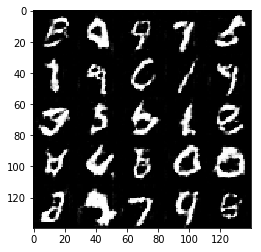

Epoch 1/2... Discriminator Loss: 2.9885... Generator Loss: 0.1291
Epoch 1/2... Discriminator Loss: 2.9995... Generator Loss: 0.2721
Epoch 1/2... Discriminator Loss: 0.9355... Generator Loss: 1.3079
Epoch 1/2... Discriminator Loss: 2.3292... Generator Loss: 0.4785
Epoch 1/2... Discriminator Loss: 1.6329... Generator Loss: 6.1802
Epoch 1/2... Discriminator Loss: 0.9036... Generator Loss: 0.8734
Epoch 1/2... Discriminator Loss: 3.5934... Generator Loss: 0.0678
Epoch 1/2... Discriminator Loss: 2.0849... Generator Loss: 0.3257
Epoch 1/2... Discriminator Loss: 2.0988... Generator Loss: 0.2502
Epoch 1/2... Discriminator Loss: 0.4980... Generator Loss: 1.2475


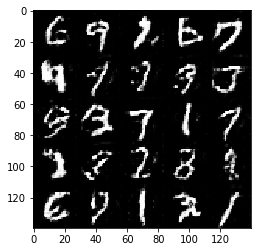

Epoch 1/2... Discriminator Loss: 1.5023... Generator Loss: 0.4007
Epoch 1/2... Discriminator Loss: 0.4527... Generator Loss: 1.6270
Epoch 1/2... Discriminator Loss: 0.5437... Generator Loss: 1.5340
Epoch 1/2... Discriminator Loss: 0.2770... Generator Loss: 2.2415
Epoch 1/2... Discriminator Loss: 2.0641... Generator Loss: 0.4688
Epoch 1/2... Discriminator Loss: 1.1700... Generator Loss: 0.7477
Epoch 1/2... Discriminator Loss: 1.3439... Generator Loss: 0.5586
Epoch 1/2... Discriminator Loss: 0.6824... Generator Loss: 0.9805
Epoch 1/2... Discriminator Loss: 1.3896... Generator Loss: 0.4112
Epoch 1/2... Discriminator Loss: 1.4541... Generator Loss: 0.7386


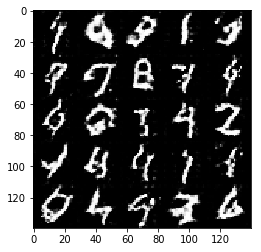

Epoch 1/2... Discriminator Loss: 1.1836... Generator Loss: 0.5307
Epoch 1/2... Discriminator Loss: 0.6945... Generator Loss: 1.2730
Epoch 1/2... Discriminator Loss: 0.8922... Generator Loss: 1.2804
Epoch 1/2... Discriminator Loss: 3.3370... Generator Loss: 0.0621
Epoch 1/2... Discriminator Loss: 1.0056... Generator Loss: 0.8342
Epoch 1/2... Discriminator Loss: 0.7803... Generator Loss: 1.1251
Epoch 1/2... Discriminator Loss: 4.9186... Generator Loss: 0.0233
Epoch 1/2... Discriminator Loss: 4.7925... Generator Loss: 0.0147
Epoch 1/2... Discriminator Loss: 0.2903... Generator Loss: 3.3428
Epoch 1/2... Discriminator Loss: 2.9247... Generator Loss: 0.0956


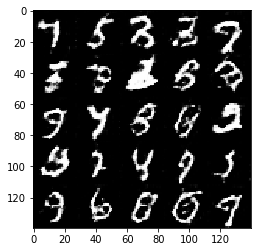

Epoch 1/2... Discriminator Loss: 0.7930... Generator Loss: 0.7919
Epoch 1/2... Discriminator Loss: 0.3105... Generator Loss: 2.4572
Epoch 1/2... Discriminator Loss: 1.6227... Generator Loss: 0.4049
Epoch 1/2... Discriminator Loss: 1.1916... Generator Loss: 0.8481
Epoch 1/2... Discriminator Loss: 0.2917... Generator Loss: 2.0063
Epoch 1/2... Discriminator Loss: 0.4288... Generator Loss: 2.5102
Epoch 1/2... Discriminator Loss: 2.7800... Generator Loss: 0.0912
Epoch 1/2... Discriminator Loss: 1.9438... Generator Loss: 0.4422
Epoch 1/2... Discriminator Loss: 1.6448... Generator Loss: 4.0218
Epoch 1/2... Discriminator Loss: 2.0072... Generator Loss: 0.3552


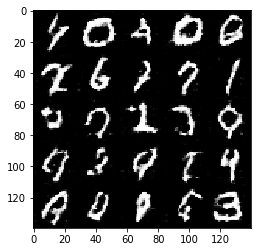

Epoch 1/2... Discriminator Loss: 0.1955... Generator Loss: 2.4453
Epoch 1/2... Discriminator Loss: 1.5986... Generator Loss: 1.6860
Epoch 1/2... Discriminator Loss: 0.6811... Generator Loss: 3.0203
Epoch 1/2... Discriminator Loss: 3.2716... Generator Loss: 0.1247
Epoch 1/2... Discriminator Loss: 0.3300... Generator Loss: 4.0489
Epoch 1/2... Discriminator Loss: 1.0758... Generator Loss: 0.6403
Epoch 1/2... Discriminator Loss: 2.1460... Generator Loss: 0.5004
Epoch 1/2... Discriminator Loss: 0.4013... Generator Loss: 1.9978
Epoch 1/2... Discriminator Loss: 2.5858... Generator Loss: 0.1862
Epoch 1/2... Discriminator Loss: 1.9037... Generator Loss: 0.2559


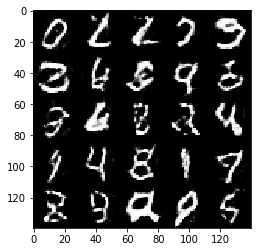

Epoch 1/2... Discriminator Loss: 1.0738... Generator Loss: 0.6295
Epoch 1/2... Discriminator Loss: 1.9230... Generator Loss: 0.3619
Epoch 1/2... Discriminator Loss: 2.2348... Generator Loss: 0.2493
Epoch 1/2... Discriminator Loss: 0.4214... Generator Loss: 1.5040
Epoch 1/2... Discriminator Loss: 1.1100... Generator Loss: 0.6819
Epoch 1/2... Discriminator Loss: 1.3086... Generator Loss: 1.0836
Epoch 1/2... Discriminator Loss: 3.1744... Generator Loss: 0.0529
Epoch 1/2... Discriminator Loss: 2.5796... Generator Loss: 0.1769
Epoch 1/2... Discriminator Loss: 3.3980... Generator Loss: 0.0450
Epoch 1/2... Discriminator Loss: 0.4080... Generator Loss: 1.7364


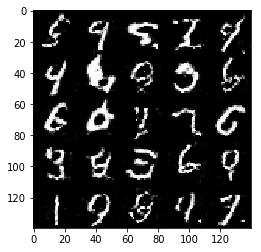

Epoch 1/2... Discriminator Loss: 4.0075... Generator Loss: 0.3144
Epoch 1/2... Discriminator Loss: 1.2721... Generator Loss: 2.1823
Epoch 1/2... Discriminator Loss: 1.1198... Generator Loss: 3.4030
Epoch 1/2... Discriminator Loss: 1.2908... Generator Loss: 0.5947
Epoch 1/2... Discriminator Loss: 2.6492... Generator Loss: 0.1310
Epoch 1/2... Discriminator Loss: 1.1905... Generator Loss: 1.2586
Epoch 1/2... Discriminator Loss: 1.1995... Generator Loss: 0.4876
Epoch 1/2... Discriminator Loss: 0.9758... Generator Loss: 1.0082
Epoch 1/2... Discriminator Loss: 2.6193... Generator Loss: 0.5203
Epoch 1/2... Discriminator Loss: 1.8333... Generator Loss: 0.3105


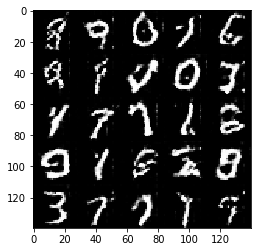

Epoch 1/2... Discriminator Loss: 1.6749... Generator Loss: 0.6295
Epoch 1/2... Discriminator Loss: 0.7326... Generator Loss: 1.5690
Epoch 1/2... Discriminator Loss: 1.3410... Generator Loss: 0.8727
Epoch 1/2... Discriminator Loss: 2.3601... Generator Loss: 0.1811
Epoch 1/2... Discriminator Loss: 0.7943... Generator Loss: 1.3471
Epoch 1/2... Discriminator Loss: 0.2252... Generator Loss: 4.4605
Epoch 1/2... Discriminator Loss: 0.6371... Generator Loss: 1.9629
Epoch 1/2... Discriminator Loss: 1.4560... Generator Loss: 0.4691
Epoch 1/2... Discriminator Loss: 1.9874... Generator Loss: 0.4383
Epoch 1/2... Discriminator Loss: 0.0429... Generator Loss: 5.0874


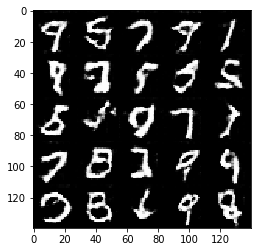

Epoch 1/2... Discriminator Loss: 5.0509... Generator Loss: 0.0705
Epoch 1/2... Discriminator Loss: 1.5363... Generator Loss: 0.6690
Epoch 1/2... Discriminator Loss: 0.2530... Generator Loss: 3.6977
Epoch 1/2... Discriminator Loss: 2.3907... Generator Loss: 0.1826
Epoch 1/2... Discriminator Loss: 0.2744... Generator Loss: 5.2631
Epoch 1/2... Discriminator Loss: 0.9159... Generator Loss: 4.2210
Epoch 1/2... Discriminator Loss: 2.8389... Generator Loss: 0.2746
Epoch 1/2... Discriminator Loss: 4.3707... Generator Loss: 0.0204
Epoch 1/2... Discriminator Loss: 0.2616... Generator Loss: 1.7075
Epoch 1/2... Discriminator Loss: 4.0254... Generator Loss: 0.0311


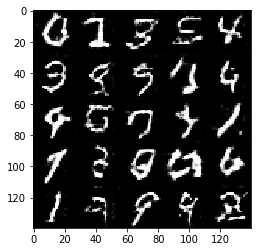

Epoch 1/2... Discriminator Loss: 1.3019... Generator Loss: 0.9166
Epoch 1/2... Discriminator Loss: 1.5787... Generator Loss: 3.7073
Epoch 1/2... Discriminator Loss: 3.5996... Generator Loss: 0.0783
Epoch 1/2... Discriminator Loss: 0.8859... Generator Loss: 1.7262
Epoch 1/2... Discriminator Loss: 1.0189... Generator Loss: 1.1993
Epoch 1/2... Discriminator Loss: 1.4677... Generator Loss: 0.7173
Epoch 1/2... Discriminator Loss: 0.6961... Generator Loss: 2.0639
Epoch 1/2... Discriminator Loss: 0.4068... Generator Loss: 2.1189
Epoch 1/2... Discriminator Loss: 1.9901... Generator Loss: 0.9520
Epoch 1/2... Discriminator Loss: 2.4684... Generator Loss: 0.3726


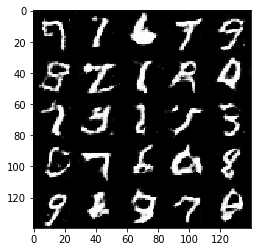

Epoch 1/2... Discriminator Loss: 3.0878... Generator Loss: 0.0604
Epoch 1/2... Discriminator Loss: 0.2459... Generator Loss: 3.1539
Epoch 1/2... Discriminator Loss: 0.3274... Generator Loss: 1.9207
Epoch 1/2... Discriminator Loss: 1.4179... Generator Loss: 0.4952
Epoch 1/2... Discriminator Loss: 0.9496... Generator Loss: 0.7607
Epoch 1/2... Discriminator Loss: 0.1569... Generator Loss: 7.4302
Epoch 1/2... Discriminator Loss: 2.7447... Generator Loss: 0.6501
Epoch 1/2... Discriminator Loss: 0.7748... Generator Loss: 1.5552
Epoch 1/2... Discriminator Loss: 1.4472... Generator Loss: 0.3848
Epoch 1/2... Discriminator Loss: 1.4692... Generator Loss: 0.4842


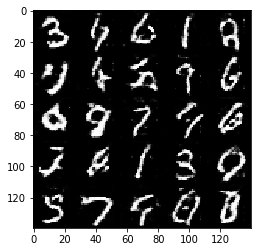

Epoch 1/2... Discriminator Loss: 1.0099... Generator Loss: 1.0976
Epoch 1/2... Discriminator Loss: 2.5136... Generator Loss: 0.3620
Epoch 1/2... Discriminator Loss: 1.0082... Generator Loss: 0.7600
Epoch 1/2... Discriminator Loss: 1.2916... Generator Loss: 0.7028
Epoch 1/2... Discriminator Loss: 3.9766... Generator Loss: 0.1169
Epoch 1/2... Discriminator Loss: 0.7518... Generator Loss: 2.0100
Epoch 1/2... Discriminator Loss: 0.6609... Generator Loss: 1.1627
Epoch 1/2... Discriminator Loss: 1.6982... Generator Loss: 5.3545
Epoch 1/2... Discriminator Loss: 0.6359... Generator Loss: 3.2683
Epoch 1/2... Discriminator Loss: 1.7097... Generator Loss: 0.5992


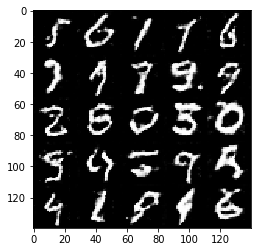

Epoch 1/2... Discriminator Loss: 2.3119... Generator Loss: 0.2003
Epoch 1/2... Discriminator Loss: 2.8310... Generator Loss: 0.2939
Epoch 1/2... Discriminator Loss: 0.4269... Generator Loss: 1.6866
Epoch 1/2... Discriminator Loss: 0.6953... Generator Loss: 0.9299
Epoch 1/2... Discriminator Loss: 0.8440... Generator Loss: 1.2167
Epoch 1/2... Discriminator Loss: 0.2052... Generator Loss: 2.9643
Epoch 1/2... Discriminator Loss: 2.2514... Generator Loss: 0.2292
Epoch 1/2... Discriminator Loss: 0.2152... Generator Loss: 2.4111
Epoch 1/2... Discriminator Loss: 1.3971... Generator Loss: 0.5617
Epoch 1/2... Discriminator Loss: 0.3988... Generator Loss: 3.7523


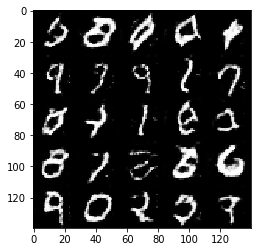

Epoch 1/2... Discriminator Loss: 0.7714... Generator Loss: 1.9090
Epoch 1/2... Discriminator Loss: 0.3634... Generator Loss: 2.0615
Epoch 1/2... Discriminator Loss: 2.5729... Generator Loss: 0.3550
Epoch 1/2... Discriminator Loss: 0.8330... Generator Loss: 0.8923
Epoch 1/2... Discriminator Loss: 1.3039... Generator Loss: 0.4731
Epoch 1/2... Discriminator Loss: 0.6943... Generator Loss: 1.4785
Epoch 1/2... Discriminator Loss: 6.0445... Generator Loss: 0.0084
Epoch 1/2... Discriminator Loss: 0.2275... Generator Loss: 2.3731
Epoch 1/2... Discriminator Loss: 2.6944... Generator Loss: 0.0774
Epoch 1/2... Discriminator Loss: 0.1280... Generator Loss: 3.6168


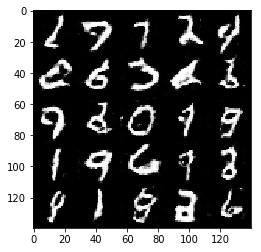

Epoch 1/2... Discriminator Loss: 1.3367... Generator Loss: 1.0722
Epoch 1/2... Discriminator Loss: 0.6407... Generator Loss: 1.0303
Epoch 1/2... Discriminator Loss: 3.2210... Generator Loss: 0.1000
Epoch 1/2... Discriminator Loss: 1.7122... Generator Loss: 0.4664
Epoch 1/2... Discriminator Loss: 2.1482... Generator Loss: 0.5778
Epoch 1/2... Discriminator Loss: 1.1431... Generator Loss: 0.6649
Epoch 1/2... Discriminator Loss: 1.1604... Generator Loss: 1.2087
Epoch 1/2... Discriminator Loss: 1.1552... Generator Loss: 0.7590
Epoch 1/2... Discriminator Loss: 0.5769... Generator Loss: 1.6071
Epoch 1/2... Discriminator Loss: 1.4354... Generator Loss: 0.9552


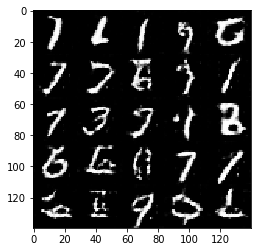

Epoch 1/2... Discriminator Loss: 0.6432... Generator Loss: 2.4821
Epoch 1/2... Discriminator Loss: 1.2717... Generator Loss: 1.2789
Epoch 1/2... Discriminator Loss: 0.1009... Generator Loss: 2.9682
Epoch 1/2... Discriminator Loss: 0.5874... Generator Loss: 1.9025
Epoch 1/2... Discriminator Loss: 0.7984... Generator Loss: 0.7921
Epoch 1/2... Discriminator Loss: 1.9181... Generator Loss: 0.2961
Epoch 1/2... Discriminator Loss: 3.7144... Generator Loss: 0.0753
Epoch 1/2... Discriminator Loss: 0.3638... Generator Loss: 1.5254
Epoch 1/2... Discriminator Loss: 0.6526... Generator Loss: 1.4972
Epoch 1/2... Discriminator Loss: 4.4031... Generator Loss: 0.0201


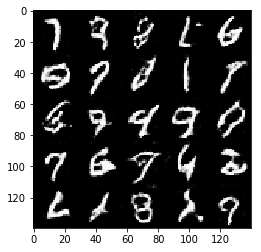

Epoch 1/2... Discriminator Loss: 0.7782... Generator Loss: 5.3437
Epoch 1/2... Discriminator Loss: 1.9422... Generator Loss: 0.5490
Epoch 1/2... Discriminator Loss: 1.5279... Generator Loss: 0.5877
Epoch 1/2... Discriminator Loss: 0.4455... Generator Loss: 2.2197
Epoch 1/2... Discriminator Loss: 0.2316... Generator Loss: 2.5202
Epoch 1/2... Discriminator Loss: 1.3160... Generator Loss: 0.7000
Epoch 1/2... Discriminator Loss: 1.4962... Generator Loss: 0.4585
Epoch 1/2... Discriminator Loss: 0.4523... Generator Loss: 4.2261
Epoch 1/2... Discriminator Loss: 1.7776... Generator Loss: 0.6606
Epoch 1/2... Discriminator Loss: 3.5424... Generator Loss: 0.0958


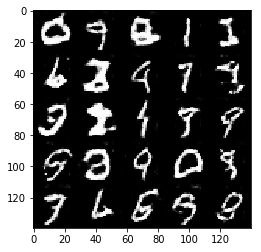

Epoch 1/2... Discriminator Loss: 0.9718... Generator Loss: 1.5193
Epoch 1/2... Discriminator Loss: 1.6535... Generator Loss: 1.2116
Epoch 1/2... Discriminator Loss: 0.5031... Generator Loss: 2.0491
Epoch 1/2... Discriminator Loss: 1.0616... Generator Loss: 1.0073
Epoch 1/2... Discriminator Loss: 2.1512... Generator Loss: 0.4382
Epoch 1/2... Discriminator Loss: 0.2004... Generator Loss: 2.4651
Epoch 1/2... Discriminator Loss: 0.4645... Generator Loss: 1.4664
Epoch 1/2... Discriminator Loss: 0.9336... Generator Loss: 0.8877
Epoch 1/2... Discriminator Loss: 0.1472... Generator Loss: 3.4990
Epoch 1/2... Discriminator Loss: 0.5280... Generator Loss: 1.8939


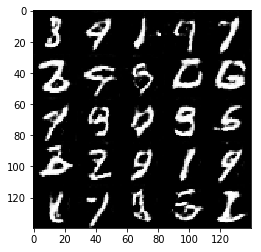

Epoch 1/2... Discriminator Loss: 0.7813... Generator Loss: 0.9113
Epoch 1/2... Discriminator Loss: 3.3952... Generator Loss: 0.1453
Epoch 1/2... Discriminator Loss: 3.8980... Generator Loss: 0.0556
Epoch 1/2... Discriminator Loss: 0.9259... Generator Loss: 1.0299
Epoch 1/2... Discriminator Loss: 1.2879... Generator Loss: 0.4860
Epoch 1/2... Discriminator Loss: 0.2051... Generator Loss: 3.1185
Epoch 1/2... Discriminator Loss: 0.4472... Generator Loss: 1.7935
Epoch 1/2... Discriminator Loss: 1.0105... Generator Loss: 0.9987
Epoch 1/2... Discriminator Loss: 1.3726... Generator Loss: 0.4647
Epoch 1/2... Discriminator Loss: 0.4252... Generator Loss: 2.3219


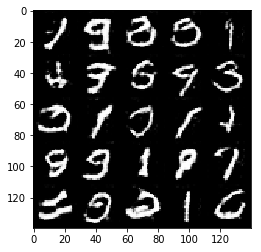

Epoch 1/2... Discriminator Loss: 1.2175... Generator Loss: 0.8000
Epoch 1/2... Discriminator Loss: 0.1357... Generator Loss: 2.6213
Epoch 1/2... Discriminator Loss: 0.6136... Generator Loss: 3.0899
Epoch 1/2... Discriminator Loss: 2.7450... Generator Loss: 0.0948
Epoch 1/2... Discriminator Loss: 0.5699... Generator Loss: 1.2726
Epoch 1/2... Discriminator Loss: 1.3149... Generator Loss: 0.6838
Epoch 1/2... Discriminator Loss: 0.2955... Generator Loss: 1.9414
Epoch 1/2... Discriminator Loss: 0.6966... Generator Loss: 1.0183
Epoch 1/2... Discriminator Loss: 0.3570... Generator Loss: 1.4782
Epoch 1/2... Discriminator Loss: 0.3029... Generator Loss: 3.1322


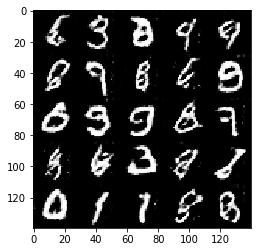

Epoch 1/2... Discriminator Loss: 4.9945... Generator Loss: 0.0373
Epoch 1/2... Discriminator Loss: 3.1143... Generator Loss: 0.0792
Epoch 1/2... Discriminator Loss: 1.4403... Generator Loss: 4.6851
Epoch 1/2... Discriminator Loss: 1.8973... Generator Loss: 0.6047
Epoch 1/2... Discriminator Loss: 2.6305... Generator Loss: 0.1839
Epoch 1/2... Discriminator Loss: 1.6244... Generator Loss: 0.3656
Epoch 1/2... Discriminator Loss: 0.2689... Generator Loss: 1.8169
Epoch 1/2... Discriminator Loss: 1.6055... Generator Loss: 0.7002
Epoch 1/2... Discriminator Loss: 2.0263... Generator Loss: 0.3711
Epoch 1/2... Discriminator Loss: 1.0259... Generator Loss: 1.1124


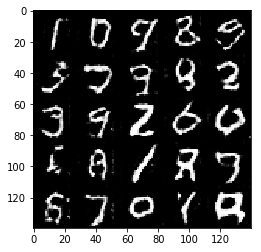

Epoch 1/2... Discriminator Loss: 0.6143... Generator Loss: 5.1353
Epoch 1/2... Discriminator Loss: 1.9120... Generator Loss: 0.4030
Epoch 1/2... Discriminator Loss: 2.7469... Generator Loss: 0.2867
Epoch 1/2... Discriminator Loss: 0.3693... Generator Loss: 1.9075
Epoch 1/2... Discriminator Loss: 0.7397... Generator Loss: 2.1078
Epoch 1/2... Discriminator Loss: 0.5349... Generator Loss: 1.1803
Epoch 1/2... Discriminator Loss: 1.9276... Generator Loss: 0.2512
Epoch 1/2... Discriminator Loss: 2.1934... Generator Loss: 0.5996
Epoch 1/2... Discriminator Loss: 0.1264... Generator Loss: 4.0539
Epoch 1/2... Discriminator Loss: 0.3931... Generator Loss: 1.6431


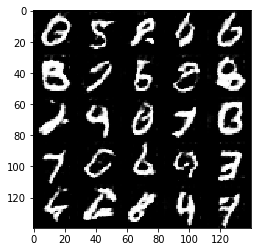

Epoch 1/2... Discriminator Loss: 0.6125... Generator Loss: 1.2725
Epoch 1/2... Discriminator Loss: 0.8996... Generator Loss: 1.1648
Epoch 1/2... Discriminator Loss: 0.6164... Generator Loss: 1.2339
Epoch 1/2... Discriminator Loss: 0.4264... Generator Loss: 2.2987
Epoch 1/2... Discriminator Loss: 1.8144... Generator Loss: 0.3642
Epoch 1/2... Discriminator Loss: 0.9383... Generator Loss: 0.9376
Epoch 1/2... Discriminator Loss: 2.5030... Generator Loss: 0.1525
Epoch 1/2... Discriminator Loss: 0.9690... Generator Loss: 3.3137
Epoch 1/2... Discriminator Loss: 1.7399... Generator Loss: 0.5919
Epoch 1/2... Discriminator Loss: 1.8148... Generator Loss: 0.4486


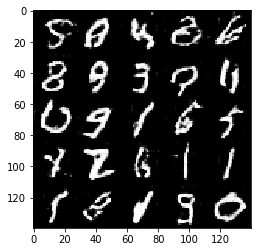

Epoch 1/2... Discriminator Loss: 0.9792... Generator Loss: 0.9780
Epoch 1/2... Discriminator Loss: 1.9501... Generator Loss: 0.2422
Epoch 1/2... Discriminator Loss: 1.6504... Generator Loss: 0.4069
Epoch 1/2... Discriminator Loss: 1.7517... Generator Loss: 0.2999
Epoch 1/2... Discriminator Loss: 0.5231... Generator Loss: 1.5597
Epoch 1/2... Discriminator Loss: 0.0764... Generator Loss: 4.1051
Epoch 1/2... Discriminator Loss: 1.1869... Generator Loss: 0.5904
Epoch 1/2... Discriminator Loss: 1.1385... Generator Loss: 0.8839
Epoch 1/2... Discriminator Loss: 0.4114... Generator Loss: 1.5725
Epoch 1/2... Discriminator Loss: 1.9807... Generator Loss: 0.3759


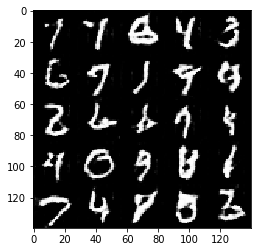

Epoch 1/2... Discriminator Loss: 0.6223... Generator Loss: 1.4861
Epoch 1/2... Discriminator Loss: 1.9797... Generator Loss: 0.5201
Epoch 1/2... Discriminator Loss: 3.0888... Generator Loss: 5.1800
Epoch 1/2... Discriminator Loss: 4.5406... Generator Loss: 7.6362
Epoch 1/2... Discriminator Loss: 2.1496... Generator Loss: 0.3488
Epoch 1/2... Discriminator Loss: 1.7556... Generator Loss: 0.7106
Epoch 1/2... Discriminator Loss: 2.2036... Generator Loss: 0.7457
Epoch 1/2... Discriminator Loss: 0.6254... Generator Loss: 4.6299
Epoch 1/2... Discriminator Loss: 1.8783... Generator Loss: 0.3180
Epoch 1/2... Discriminator Loss: 0.7572... Generator Loss: 1.4327


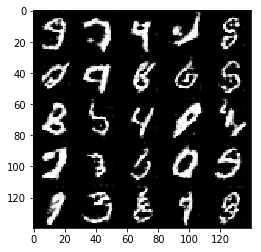

Epoch 1/2... Discriminator Loss: 0.2451... Generator Loss: 2.7740
Epoch 1/2... Discriminator Loss: 1.6297... Generator Loss: 0.7253
Epoch 1/2... Discriminator Loss: 1.2289... Generator Loss: 0.6227
Epoch 1/2... Discriminator Loss: 1.2335... Generator Loss: 1.0582
Epoch 1/2... Discriminator Loss: 0.9446... Generator Loss: 0.7533
Epoch 1/2... Discriminator Loss: 1.6469... Generator Loss: 1.1134
Epoch 1/2... Discriminator Loss: 2.1290... Generator Loss: 0.1944
Epoch 1/2... Discriminator Loss: 3.1186... Generator Loss: 0.1149
Epoch 1/2... Discriminator Loss: 0.8064... Generator Loss: 1.0762
Epoch 1/2... Discriminator Loss: 0.8110... Generator Loss: 1.5865


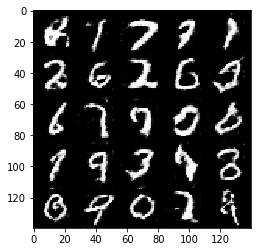

Epoch 1/2... Discriminator Loss: 1.4756... Generator Loss: 0.9695
Epoch 1/2... Discriminator Loss: 0.8960... Generator Loss: 0.9113
Epoch 1/2... Discriminator Loss: 2.6453... Generator Loss: 0.2272
Epoch 1/2... Discriminator Loss: 1.8587... Generator Loss: 0.5437
Epoch 1/2... Discriminator Loss: 0.6325... Generator Loss: 1.5634
Epoch 1/2... Discriminator Loss: 0.9466... Generator Loss: 0.8277
Epoch 1/2... Discriminator Loss: 0.2090... Generator Loss: 2.0109
Epoch 1/2... Discriminator Loss: 1.2715... Generator Loss: 0.5070
Epoch 1/2... Discriminator Loss: 1.2486... Generator Loss: 0.8597
Epoch 1/2... Discriminator Loss: 0.5766... Generator Loss: 1.3623


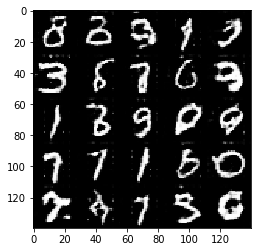

Epoch 1/2... Discriminator Loss: 1.0819... Generator Loss: 0.8931
Epoch 1/2... Discriminator Loss: 0.4313... Generator Loss: 2.1033
Epoch 1/2... Discriminator Loss: 2.8911... Generator Loss: 0.1532
Epoch 1/2... Discriminator Loss: 0.3756... Generator Loss: 5.0988
Epoch 1/2... Discriminator Loss: 2.0641... Generator Loss: 0.6785
Epoch 1/2... Discriminator Loss: 0.8027... Generator Loss: 1.1437
Epoch 1/2... Discriminator Loss: 0.5535... Generator Loss: 1.9100
Epoch 1/2... Discriminator Loss: 1.3322... Generator Loss: 0.7906
Epoch 1/2... Discriminator Loss: 0.3378... Generator Loss: 1.6637
Epoch 1/2... Discriminator Loss: 1.2179... Generator Loss: 1.6760


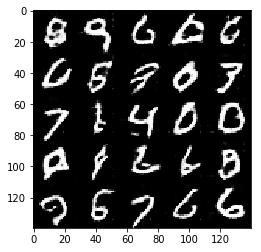

Epoch 1/2... Discriminator Loss: 0.6535... Generator Loss: 1.7816
Epoch 1/2... Discriminator Loss: 3.6534... Generator Loss: 0.0470
Epoch 1/2... Discriminator Loss: 1.0446... Generator Loss: 0.7546
Epoch 1/2... Discriminator Loss: 2.9078... Generator Loss: 0.1854
Epoch 1/2... Discriminator Loss: 2.1265... Generator Loss: 0.4032
Epoch 1/2... Discriminator Loss: 0.5204... Generator Loss: 1.5934
Epoch 1/2... Discriminator Loss: 0.3163... Generator Loss: 3.2267
Epoch 1/2... Discriminator Loss: 1.4408... Generator Loss: 0.6699
Epoch 1/2... Discriminator Loss: 0.9456... Generator Loss: 1.1242
Epoch 1/2... Discriminator Loss: 3.4080... Generator Loss: 0.0837


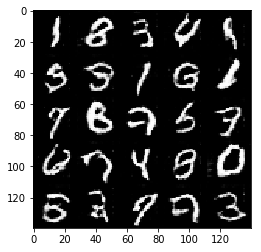

Epoch 1/2... Discriminator Loss: 0.6002... Generator Loss: 1.1695
Epoch 1/2... Discriminator Loss: 1.2997... Generator Loss: 0.5083
Epoch 1/2... Discriminator Loss: 1.1110... Generator Loss: 0.9937
Epoch 1/2... Discriminator Loss: 2.6220... Generator Loss: 0.1378
Epoch 1/2... Discriminator Loss: 0.3603... Generator Loss: 2.8901
Epoch 1/2... Discriminator Loss: 0.5047... Generator Loss: 5.3346
Epoch 1/2... Discriminator Loss: 0.4457... Generator Loss: 1.7408
Epoch 1/2... Discriminator Loss: 0.8356... Generator Loss: 1.0955
Epoch 1/2... Discriminator Loss: 2.2456... Generator Loss: 0.1822
Epoch 1/2... Discriminator Loss: 0.1719... Generator Loss: 5.5415


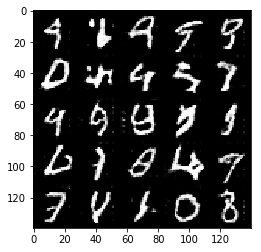

Epoch 1/2... Discriminator Loss: 4.2586... Generator Loss: 0.1489
Epoch 1/2... Discriminator Loss: 0.7599... Generator Loss: 1.0570
Epoch 1/2... Discriminator Loss: 2.4839... Generator Loss: 0.2254
Epoch 1/2... Discriminator Loss: 1.1663... Generator Loss: 0.9945
Epoch 1/2... Discriminator Loss: 0.9516... Generator Loss: 1.7410
Epoch 1/2... Discriminator Loss: 1.1258... Generator Loss: 0.5774
Epoch 1/2... Discriminator Loss: 1.0642... Generator Loss: 1.6053
Epoch 1/2... Discriminator Loss: 2.4919... Generator Loss: 0.1768
Epoch 1/2... Discriminator Loss: 0.2383... Generator Loss: 2.1172
Epoch 1/2... Discriminator Loss: 0.3748... Generator Loss: 2.2532


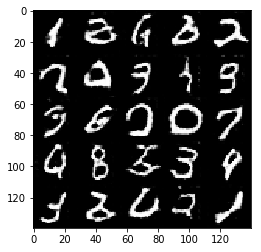

Epoch 2/2... Discriminator Loss: 1.1493... Generator Loss: 0.6432
Epoch 2/2... Discriminator Loss: 0.8027... Generator Loss: 0.9703
Epoch 2/2... Discriminator Loss: 0.2342... Generator Loss: 2.1221
Epoch 2/2... Discriminator Loss: 1.0173... Generator Loss: 1.1283
Epoch 2/2... Discriminator Loss: 0.4685... Generator Loss: 1.4590
Epoch 2/2... Discriminator Loss: 1.0406... Generator Loss: 2.1268
Epoch 2/2... Discriminator Loss: 0.5517... Generator Loss: 2.6895
Epoch 2/2... Discriminator Loss: 0.2990... Generator Loss: 3.5414
Epoch 2/2... Discriminator Loss: 0.1955... Generator Loss: 2.1298
Epoch 2/2... Discriminator Loss: 1.9195... Generator Loss: 0.4218


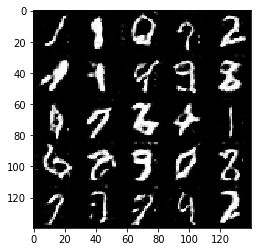

Epoch 2/2... Discriminator Loss: 2.2171... Generator Loss: 5.5528
Epoch 2/2... Discriminator Loss: 3.2711... Generator Loss: 0.1869
Epoch 2/2... Discriminator Loss: 2.6812... Generator Loss: 0.3868
Epoch 2/2... Discriminator Loss: 1.9466... Generator Loss: 0.7792
Epoch 2/2... Discriminator Loss: 1.3871... Generator Loss: 1.1867
Epoch 2/2... Discriminator Loss: 1.4269... Generator Loss: 0.3714
Epoch 2/2... Discriminator Loss: 2.5950... Generator Loss: 0.4318
Epoch 2/2... Discriminator Loss: 0.0703... Generator Loss: 6.1773
Epoch 2/2... Discriminator Loss: 0.8844... Generator Loss: 1.1781
Epoch 2/2... Discriminator Loss: 0.8415... Generator Loss: 0.8179


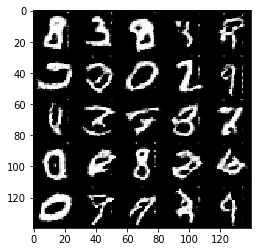

Epoch 2/2... Discriminator Loss: 1.6224... Generator Loss: 0.5598
Epoch 2/2... Discriminator Loss: 0.3426... Generator Loss: 2.3306
Epoch 2/2... Discriminator Loss: 0.1966... Generator Loss: 3.2811
Epoch 2/2... Discriminator Loss: 0.6656... Generator Loss: 1.5363
Epoch 2/2... Discriminator Loss: 0.0608... Generator Loss: 3.5171
Epoch 2/2... Discriminator Loss: 0.7220... Generator Loss: 1.3144
Epoch 2/2... Discriminator Loss: 1.6337... Generator Loss: 0.6031
Epoch 2/2... Discriminator Loss: 0.2394... Generator Loss: 2.9156
Epoch 2/2... Discriminator Loss: 1.7516... Generator Loss: 0.3640
Epoch 2/2... Discriminator Loss: 1.0224... Generator Loss: 0.7595


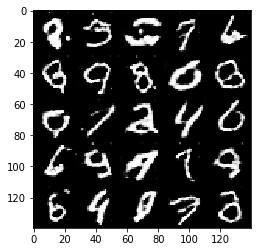

Epoch 2/2... Discriminator Loss: 0.0871... Generator Loss: 3.0678
Epoch 2/2... Discriminator Loss: 0.2826... Generator Loss: 2.2028
Epoch 2/2... Discriminator Loss: 0.8564... Generator Loss: 1.2568
Epoch 2/2... Discriminator Loss: 2.4445... Generator Loss: 0.2340
Epoch 2/2... Discriminator Loss: 4.9562... Generator Loss: 0.0222
Epoch 2/2... Discriminator Loss: 4.1337... Generator Loss: 0.0449
Epoch 2/2... Discriminator Loss: 0.9582... Generator Loss: 0.8612
Epoch 2/2... Discriminator Loss: 1.0706... Generator Loss: 0.6764
Epoch 2/2... Discriminator Loss: 0.8012... Generator Loss: 1.2663
Epoch 2/2... Discriminator Loss: 0.4715... Generator Loss: 1.2653


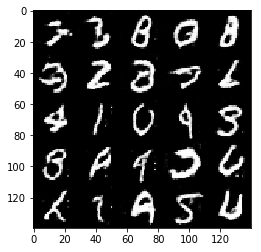

Epoch 2/2... Discriminator Loss: 4.0384... Generator Loss: 9.1683
Epoch 2/2... Discriminator Loss: 0.5611... Generator Loss: 1.3021
Epoch 2/2... Discriminator Loss: 1.0824... Generator Loss: 0.5866
Epoch 2/2... Discriminator Loss: 1.4996... Generator Loss: 0.9099
Epoch 2/2... Discriminator Loss: 1.9430... Generator Loss: 0.5663
Epoch 2/2... Discriminator Loss: 0.3164... Generator Loss: 1.8268
Epoch 2/2... Discriminator Loss: 0.0933... Generator Loss: 4.1748
Epoch 2/2... Discriminator Loss: 0.6430... Generator Loss: 2.3774
Epoch 2/2... Discriminator Loss: 0.9054... Generator Loss: 1.3848
Epoch 2/2... Discriminator Loss: 1.4316... Generator Loss: 0.5127


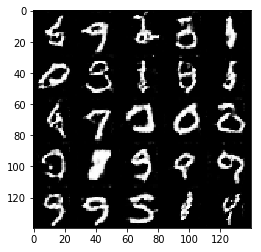

Epoch 2/2... Discriminator Loss: 0.4337... Generator Loss: 1.4003
Epoch 2/2... Discriminator Loss: 1.4763... Generator Loss: 0.3979
Epoch 2/2... Discriminator Loss: 3.3961... Generator Loss: 0.1046
Epoch 2/2... Discriminator Loss: 1.1637... Generator Loss: 1.1004
Epoch 2/2... Discriminator Loss: 0.3691... Generator Loss: 2.1084
Epoch 2/2... Discriminator Loss: 0.4958... Generator Loss: 3.3058
Epoch 2/2... Discriminator Loss: 0.4835... Generator Loss: 1.6809
Epoch 2/2... Discriminator Loss: 0.0618... Generator Loss: 5.7837
Epoch 2/2... Discriminator Loss: 0.1118... Generator Loss: 3.2841
Epoch 2/2... Discriminator Loss: 0.7421... Generator Loss: 0.9120


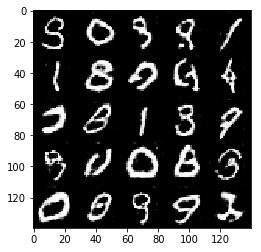

Epoch 2/2... Discriminator Loss: 0.6451... Generator Loss: 1.8782
Epoch 2/2... Discriminator Loss: 1.3602... Generator Loss: 0.5661
Epoch 2/2... Discriminator Loss: 0.2174... Generator Loss: 3.0868
Epoch 2/2... Discriminator Loss: 0.5877... Generator Loss: 1.1389
Epoch 2/2... Discriminator Loss: 2.0008... Generator Loss: 0.3446
Epoch 2/2... Discriminator Loss: 0.1819... Generator Loss: 2.2610
Epoch 2/2... Discriminator Loss: 0.3092... Generator Loss: 2.6369
Epoch 2/2... Discriminator Loss: 0.8294... Generator Loss: 1.8648
Epoch 2/2... Discriminator Loss: 1.8685... Generator Loss: 0.4268
Epoch 2/2... Discriminator Loss: 0.2900... Generator Loss: 5.6102


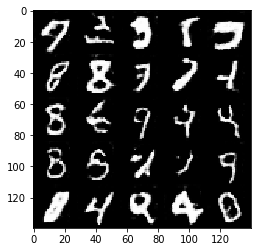

Epoch 2/2... Discriminator Loss: 0.6263... Generator Loss: 1.8779
Epoch 2/2... Discriminator Loss: 0.3973... Generator Loss: 1.7335
Epoch 2/2... Discriminator Loss: 0.7966... Generator Loss: 1.1383
Epoch 2/2... Discriminator Loss: 0.1582... Generator Loss: 3.6688
Epoch 2/2... Discriminator Loss: 0.1418... Generator Loss: 3.5143
Epoch 2/2... Discriminator Loss: 2.4719... Generator Loss: 0.6365
Epoch 2/2... Discriminator Loss: 1.9948... Generator Loss: 5.2014
Epoch 2/2... Discriminator Loss: 0.9668... Generator Loss: 1.5331
Epoch 2/2... Discriminator Loss: 0.6403... Generator Loss: 2.9432
Epoch 2/2... Discriminator Loss: 1.3792... Generator Loss: 0.4564


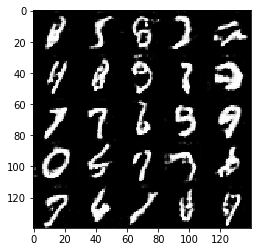

Epoch 2/2... Discriminator Loss: 1.8008... Generator Loss: 0.4349
Epoch 2/2... Discriminator Loss: 0.7655... Generator Loss: 1.4383
Epoch 2/2... Discriminator Loss: 1.1300... Generator Loss: 0.9968
Epoch 2/2... Discriminator Loss: 1.6675... Generator Loss: 0.4454
Epoch 2/2... Discriminator Loss: 0.9781... Generator Loss: 0.7507
Epoch 2/2... Discriminator Loss: 0.6311... Generator Loss: 4.0916
Epoch 2/2... Discriminator Loss: 1.4581... Generator Loss: 1.1473
Epoch 2/2... Discriminator Loss: 0.1273... Generator Loss: 3.4042
Epoch 2/2... Discriminator Loss: 1.1397... Generator Loss: 0.5853
Epoch 2/2... Discriminator Loss: 2.3459... Generator Loss: 0.1891


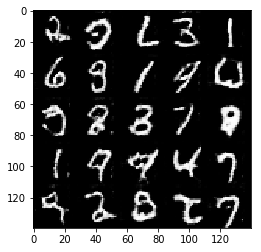

Epoch 2/2... Discriminator Loss: 0.7875... Generator Loss: 1.1786
Epoch 2/2... Discriminator Loss: 2.0824... Generator Loss: 0.2816
Epoch 2/2... Discriminator Loss: 1.7655... Generator Loss: 0.2629
Epoch 2/2... Discriminator Loss: 1.2133... Generator Loss: 1.0743
Epoch 2/2... Discriminator Loss: 0.8161... Generator Loss: 1.0972
Epoch 2/2... Discriminator Loss: 0.6408... Generator Loss: 1.6154
Epoch 2/2... Discriminator Loss: 1.1509... Generator Loss: 6.8753
Epoch 2/2... Discriminator Loss: 0.1006... Generator Loss: 6.4053
Epoch 2/2... Discriminator Loss: 0.2736... Generator Loss: 5.4880
Epoch 2/2... Discriminator Loss: 1.1026... Generator Loss: 0.9702


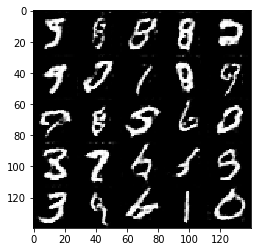

Epoch 2/2... Discriminator Loss: 0.1624... Generator Loss: 3.0456
Epoch 2/2... Discriminator Loss: 0.3841... Generator Loss: 1.9612
Epoch 2/2... Discriminator Loss: 1.1970... Generator Loss: 0.8059
Epoch 2/2... Discriminator Loss: 0.9751... Generator Loss: 0.9384
Epoch 2/2... Discriminator Loss: 0.3610... Generator Loss: 2.5729
Epoch 2/2... Discriminator Loss: 0.5417... Generator Loss: 1.8074
Epoch 2/2... Discriminator Loss: 0.4801... Generator Loss: 1.4793
Epoch 2/2... Discriminator Loss: 0.2526... Generator Loss: 2.2679
Epoch 2/2... Discriminator Loss: 3.1765... Generator Loss: 0.0679
Epoch 2/2... Discriminator Loss: 0.9072... Generator Loss: 1.4786


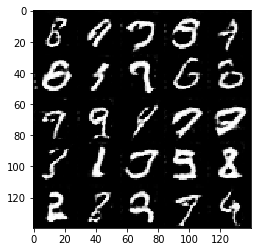

Epoch 2/2... Discriminator Loss: 0.6531... Generator Loss: 1.5098
Epoch 2/2... Discriminator Loss: 0.4225... Generator Loss: 1.6030
Epoch 2/2... Discriminator Loss: 0.8923... Generator Loss: 0.9446
Epoch 2/2... Discriminator Loss: 2.7727... Generator Loss: 0.1526
Epoch 2/2... Discriminator Loss: 1.2884... Generator Loss: 0.5059
Epoch 2/2... Discriminator Loss: 0.4484... Generator Loss: 3.0183
Epoch 2/2... Discriminator Loss: 3.2023... Generator Loss: 0.2866
Epoch 2/2... Discriminator Loss: 0.7229... Generator Loss: 1.4423
Epoch 2/2... Discriminator Loss: 1.2975... Generator Loss: 5.7717
Epoch 2/2... Discriminator Loss: 0.9446... Generator Loss: 0.8989


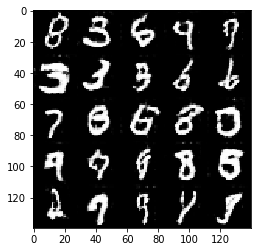

Epoch 2/2... Discriminator Loss: 1.8400... Generator Loss: 1.0200
Epoch 2/2... Discriminator Loss: 0.6259... Generator Loss: 1.4742
Epoch 2/2... Discriminator Loss: 0.8352... Generator Loss: 1.0368
Epoch 2/2... Discriminator Loss: 0.4660... Generator Loss: 2.4821
Epoch 2/2... Discriminator Loss: 0.6299... Generator Loss: 1.2251
Epoch 2/2... Discriminator Loss: 0.5235... Generator Loss: 1.5047
Epoch 2/2... Discriminator Loss: 0.4253... Generator Loss: 3.9524
Epoch 2/2... Discriminator Loss: 1.1359... Generator Loss: 1.0340
Epoch 2/2... Discriminator Loss: 0.7172... Generator Loss: 1.2093
Epoch 2/2... Discriminator Loss: 1.1864... Generator Loss: 0.4921


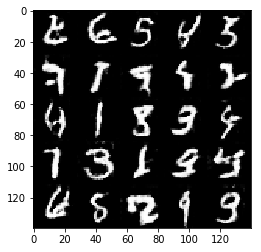

Epoch 2/2... Discriminator Loss: 0.4236... Generator Loss: 1.5346
Epoch 2/2... Discriminator Loss: 1.8234... Generator Loss: 0.6697
Epoch 2/2... Discriminator Loss: 0.0381... Generator Loss: 5.3043
Epoch 2/2... Discriminator Loss: 0.2320... Generator Loss: 2.0150
Epoch 2/2... Discriminator Loss: 1.6312... Generator Loss: 0.5228
Epoch 2/2... Discriminator Loss: 1.3183... Generator Loss: 0.3625
Epoch 2/2... Discriminator Loss: 0.1591... Generator Loss: 3.0780
Epoch 2/2... Discriminator Loss: 0.4486... Generator Loss: 2.0261
Epoch 2/2... Discriminator Loss: 0.6859... Generator Loss: 1.3905
Epoch 2/2... Discriminator Loss: 2.3167... Generator Loss: 0.1940


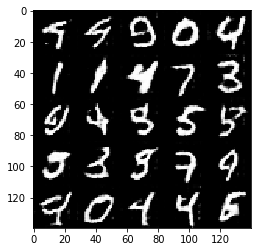

Epoch 2/2... Discriminator Loss: 0.3040... Generator Loss: 2.2606
Epoch 2/2... Discriminator Loss: 1.0547... Generator Loss: 0.9105
Epoch 2/2... Discriminator Loss: 0.2202... Generator Loss: 4.1024
Epoch 2/2... Discriminator Loss: 0.1932... Generator Loss: 7.7833
Epoch 2/2... Discriminator Loss: 1.5596... Generator Loss: 0.6731
Epoch 2/2... Discriminator Loss: 0.3928... Generator Loss: 1.6567
Epoch 2/2... Discriminator Loss: 2.5942... Generator Loss: 0.2752
Epoch 2/2... Discriminator Loss: 3.9257... Generator Loss: 0.0391
Epoch 2/2... Discriminator Loss: 2.9312... Generator Loss: 7.4327
Epoch 2/2... Discriminator Loss: 0.3624... Generator Loss: 3.0440


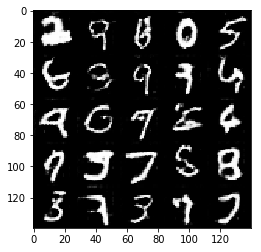

Epoch 2/2... Discriminator Loss: 0.4111... Generator Loss: 1.8147
Epoch 2/2... Discriminator Loss: 1.4035... Generator Loss: 0.8265
Epoch 2/2... Discriminator Loss: 1.0495... Generator Loss: 1.3083
Epoch 2/2... Discriminator Loss: 2.2952... Generator Loss: 0.3991
Epoch 2/2... Discriminator Loss: 1.0347... Generator Loss: 0.9244
Epoch 2/2... Discriminator Loss: 0.1082... Generator Loss: 2.8245
Epoch 2/2... Discriminator Loss: 0.2768... Generator Loss: 1.9894
Epoch 2/2... Discriminator Loss: 0.1369... Generator Loss: 4.9512
Epoch 2/2... Discriminator Loss: 0.1633... Generator Loss: 2.9726
Epoch 2/2... Discriminator Loss: 0.5272... Generator Loss: 1.3533


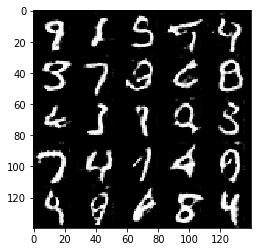

Epoch 2/2... Discriminator Loss: 2.3682... Generator Loss: 0.7894
Epoch 2/2... Discriminator Loss: 3.9039... Generator Loss: 0.0312
Epoch 2/2... Discriminator Loss: 0.3410... Generator Loss: 2.8832
Epoch 2/2... Discriminator Loss: 0.3182... Generator Loss: 2.0712
Epoch 2/2... Discriminator Loss: 1.8510... Generator Loss: 0.3387
Epoch 2/2... Discriminator Loss: 0.3971... Generator Loss: 2.0268
Epoch 2/2... Discriminator Loss: 0.3495... Generator Loss: 1.7389
Epoch 2/2... Discriminator Loss: 3.8936... Generator Loss: 0.1228
Epoch 2/2... Discriminator Loss: 1.3397... Generator Loss: 5.3884
Epoch 2/2... Discriminator Loss: 1.3841... Generator Loss: 4.7527


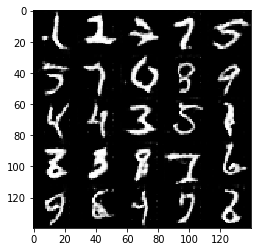

Epoch 2/2... Discriminator Loss: 0.3764... Generator Loss: 1.9391
Epoch 2/2... Discriminator Loss: 1.2560... Generator Loss: 0.5020
Epoch 2/2... Discriminator Loss: 0.1531... Generator Loss: 6.7200
Epoch 2/2... Discriminator Loss: 1.6210... Generator Loss: 5.8895
Epoch 2/2... Discriminator Loss: 0.9263... Generator Loss: 1.3247
Epoch 2/2... Discriminator Loss: 0.4150... Generator Loss: 1.8197
Epoch 2/2... Discriminator Loss: 0.2224... Generator Loss: 4.6418
Epoch 2/2... Discriminator Loss: 0.8229... Generator Loss: 1.3685
Epoch 2/2... Discriminator Loss: 4.0141... Generator Loss: 0.0433
Epoch 2/2... Discriminator Loss: 2.2840... Generator Loss: 0.2221


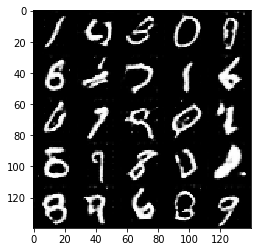

Epoch 2/2... Discriminator Loss: 0.5866... Generator Loss: 1.3253
Epoch 2/2... Discriminator Loss: 3.8390... Generator Loss: 0.0406
Epoch 2/2... Discriminator Loss: 0.1407... Generator Loss: 3.2539
Epoch 2/2... Discriminator Loss: 0.2835... Generator Loss: 2.9112
Epoch 2/2... Discriminator Loss: 1.8519... Generator Loss: 0.2491
Epoch 2/2... Discriminator Loss: 2.5203... Generator Loss: 6.0729
Epoch 2/2... Discriminator Loss: 0.2724... Generator Loss: 2.7843
Epoch 2/2... Discriminator Loss: 3.6669... Generator Loss: 0.0921
Epoch 2/2... Discriminator Loss: 0.7844... Generator Loss: 1.5665
Epoch 2/2... Discriminator Loss: 0.9385... Generator Loss: 1.0718


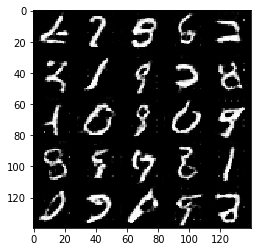

Epoch 2/2... Discriminator Loss: 0.9473... Generator Loss: 1.0985
Epoch 2/2... Discriminator Loss: 0.1879... Generator Loss: 3.2543
Epoch 2/2... Discriminator Loss: 0.5386... Generator Loss: 1.7256
Epoch 2/2... Discriminator Loss: 0.5669... Generator Loss: 1.1984
Epoch 2/2... Discriminator Loss: 0.3023... Generator Loss: 3.2490
Epoch 2/2... Discriminator Loss: 1.3159... Generator Loss: 0.5595
Epoch 2/2... Discriminator Loss: 0.8911... Generator Loss: 0.7322
Epoch 2/2... Discriminator Loss: 0.0718... Generator Loss: 3.8698
Epoch 2/2... Discriminator Loss: 1.7540... Generator Loss: 0.5084
Epoch 2/2... Discriminator Loss: 0.7213... Generator Loss: 2.0430


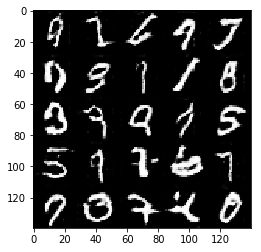

Epoch 2/2... Discriminator Loss: 0.1741... Generator Loss: 2.1034
Epoch 2/2... Discriminator Loss: 2.4302... Generator Loss: 0.1299
Epoch 2/2... Discriminator Loss: 2.9266... Generator Loss: 0.1184
Epoch 2/2... Discriminator Loss: 0.5366... Generator Loss: 1.2695
Epoch 2/2... Discriminator Loss: 1.7316... Generator Loss: 0.2750
Epoch 2/2... Discriminator Loss: 0.3737... Generator Loss: 1.9343
Epoch 2/2... Discriminator Loss: 0.8582... Generator Loss: 1.4705
Epoch 2/2... Discriminator Loss: 1.1096... Generator Loss: 0.6472
Epoch 2/2... Discriminator Loss: 1.2418... Generator Loss: 0.5185
Epoch 2/2... Discriminator Loss: 0.1480... Generator Loss: 2.6044


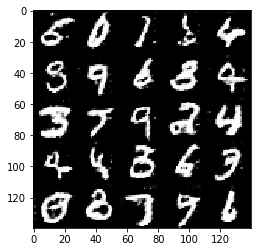

Epoch 2/2... Discriminator Loss: 0.5854... Generator Loss: 1.4558
Epoch 2/2... Discriminator Loss: 0.5279... Generator Loss: 2.8141
Epoch 2/2... Discriminator Loss: 0.6934... Generator Loss: 1.6449
Epoch 2/2... Discriminator Loss: 0.8356... Generator Loss: 1.7663
Epoch 2/2... Discriminator Loss: 0.8040... Generator Loss: 1.8631
Epoch 2/2... Discriminator Loss: 2.8374... Generator Loss: 0.1827
Epoch 2/2... Discriminator Loss: 0.0242... Generator Loss: 5.1476
Epoch 2/2... Discriminator Loss: 0.4138... Generator Loss: 1.3015
Epoch 2/2... Discriminator Loss: 0.4834... Generator Loss: 1.5577
Epoch 2/2... Discriminator Loss: 1.5371... Generator Loss: 0.8072


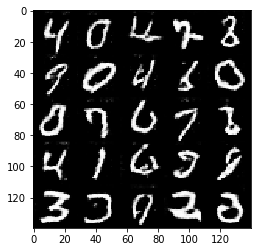

Epoch 2/2... Discriminator Loss: 0.5203... Generator Loss: 1.8705
Epoch 2/2... Discriminator Loss: 2.2626... Generator Loss: 0.2458
Epoch 2/2... Discriminator Loss: 0.6867... Generator Loss: 1.1820
Epoch 2/2... Discriminator Loss: 2.3041... Generator Loss: 0.6383
Epoch 2/2... Discriminator Loss: 1.8578... Generator Loss: 0.2782
Epoch 2/2... Discriminator Loss: 0.6029... Generator Loss: 0.9930
Epoch 2/2... Discriminator Loss: 0.9994... Generator Loss: 1.0949
Epoch 2/2... Discriminator Loss: 0.7868... Generator Loss: 1.0414
Epoch 2/2... Discriminator Loss: 0.5582... Generator Loss: 1.2907
Epoch 2/2... Discriminator Loss: 0.4965... Generator Loss: 1.6629


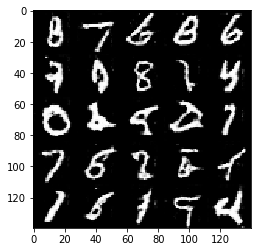

Epoch 2/2... Discriminator Loss: 0.0229... Generator Loss: 5.5183
Epoch 2/2... Discriminator Loss: 2.8350... Generator Loss: 0.1110
Epoch 2/2... Discriminator Loss: 0.0466... Generator Loss: 3.5107
Epoch 2/2... Discriminator Loss: 0.6948... Generator Loss: 1.0888
Epoch 2/2... Discriminator Loss: 0.0899... Generator Loss: 4.6394
Epoch 2/2... Discriminator Loss: 0.8055... Generator Loss: 1.6065
Epoch 2/2... Discriminator Loss: 0.2734... Generator Loss: 2.3086
Epoch 2/2... Discriminator Loss: 3.5029... Generator Loss: 0.2159
Epoch 2/2... Discriminator Loss: 2.5036... Generator Loss: 0.1770
Epoch 2/2... Discriminator Loss: 2.6303... Generator Loss: 0.3193


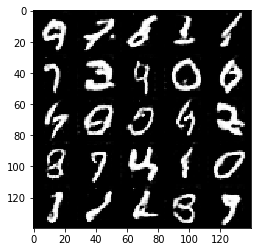

Epoch 2/2... Discriminator Loss: 3.2439... Generator Loss: 0.0983
Epoch 2/2... Discriminator Loss: 0.0140... Generator Loss: 5.1019
Epoch 2/2... Discriminator Loss: 0.8053... Generator Loss: 1.4131
Epoch 2/2... Discriminator Loss: 2.1765... Generator Loss: 0.1780
Epoch 2/2... Discriminator Loss: 2.5511... Generator Loss: 0.2031
Epoch 2/2... Discriminator Loss: 0.2332... Generator Loss: 2.9147
Epoch 2/2... Discriminator Loss: 0.4426... Generator Loss: 1.6914
Epoch 2/2... Discriminator Loss: 0.4813... Generator Loss: 1.4837
Epoch 2/2... Discriminator Loss: 3.4014... Generator Loss: 0.0535
Epoch 2/2... Discriminator Loss: 0.1735... Generator Loss: 2.4406


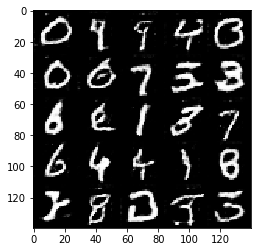

Epoch 2/2... Discriminator Loss: 4.2260... Generator Loss: 0.0727
Epoch 2/2... Discriminator Loss: 0.4961... Generator Loss: 2.3109
Epoch 2/2... Discriminator Loss: 0.5150... Generator Loss: 2.5976
Epoch 2/2... Discriminator Loss: 0.1625... Generator Loss: 3.8119
Epoch 2/2... Discriminator Loss: 1.4232... Generator Loss: 0.6564
Epoch 2/2... Discriminator Loss: 0.9631... Generator Loss: 0.9623
Epoch 2/2... Discriminator Loss: 3.5290... Generator Loss: 0.0922
Epoch 2/2... Discriminator Loss: 1.0921... Generator Loss: 0.7218
Epoch 2/2... Discriminator Loss: 1.6528... Generator Loss: 0.4427
Epoch 2/2... Discriminator Loss: 3.1113... Generator Loss: 0.0814


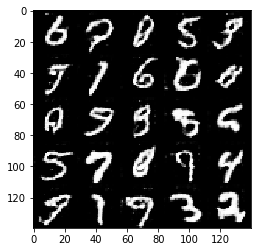

Epoch 2/2... Discriminator Loss: 0.4520... Generator Loss: 1.8618
Epoch 2/2... Discriminator Loss: 1.3535... Generator Loss: 0.9258
Epoch 2/2... Discriminator Loss: 0.6991... Generator Loss: 1.4590
Epoch 2/2... Discriminator Loss: 3.6362... Generator Loss: 0.1525
Epoch 2/2... Discriminator Loss: 0.7217... Generator Loss: 0.8154
Epoch 2/2... Discriminator Loss: 0.9620... Generator Loss: 0.7507
Epoch 2/2... Discriminator Loss: 1.1606... Generator Loss: 0.9080
Epoch 2/2... Discriminator Loss: 1.2856... Generator Loss: 1.0824
Epoch 2/2... Discriminator Loss: 0.6860... Generator Loss: 1.4538
Epoch 2/2... Discriminator Loss: 0.3530... Generator Loss: 2.6791


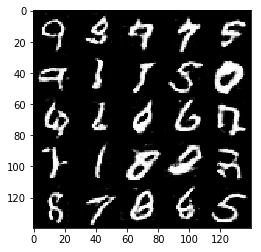

Epoch 2/2... Discriminator Loss: 1.9762... Generator Loss: 0.3121
Epoch 2/2... Discriminator Loss: 0.2553... Generator Loss: 2.4598
Epoch 2/2... Discriminator Loss: 1.0977... Generator Loss: 0.8922
Epoch 2/2... Discriminator Loss: 1.1362... Generator Loss: 0.8255
Epoch 2/2... Discriminator Loss: 0.3662... Generator Loss: 1.6576
Epoch 2/2... Discriminator Loss: 0.7495... Generator Loss: 1.2670
Epoch 2/2... Discriminator Loss: 3.8943... Generator Loss: 0.0767
Epoch 2/2... Discriminator Loss: 3.4284... Generator Loss: 0.0850
Epoch 2/2... Discriminator Loss: 0.6688... Generator Loss: 2.6906
Epoch 2/2... Discriminator Loss: 0.8837... Generator Loss: 0.6605


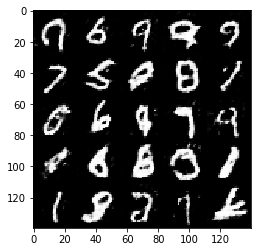

Epoch 2/2... Discriminator Loss: 0.2091... Generator Loss: 2.6724
Epoch 2/2... Discriminator Loss: 0.8271... Generator Loss: 0.8165
Epoch 2/2... Discriminator Loss: 1.4498... Generator Loss: 1.1978
Epoch 2/2... Discriminator Loss: 1.1430... Generator Loss: 3.7747
Epoch 2/2... Discriminator Loss: 0.9446... Generator Loss: 0.9042
Epoch 2/2... Discriminator Loss: 0.2727... Generator Loss: 2.2590
Epoch 2/2... Discriminator Loss: 0.1078... Generator Loss: 4.4725
Epoch 2/2... Discriminator Loss: 0.1667... Generator Loss: 2.9330
Epoch 2/2... Discriminator Loss: 1.4031... Generator Loss: 0.5755
Epoch 2/2... Discriminator Loss: 2.9518... Generator Loss: 0.2352


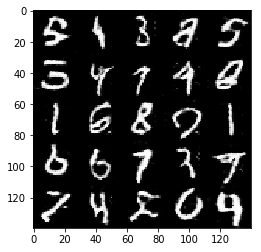

Epoch 2/2... Discriminator Loss: 1.2775... Generator Loss: 0.7248
Epoch 2/2... Discriminator Loss: 0.4492... Generator Loss: 1.4885
Epoch 2/2... Discriminator Loss: 0.7016... Generator Loss: 1.5693
Epoch 2/2... Discriminator Loss: 0.5698... Generator Loss: 1.9476
Epoch 2/2... Discriminator Loss: 0.6043... Generator Loss: 2.3889
Epoch 2/2... Discriminator Loss: 0.0742... Generator Loss: 3.1679
Epoch 2/2... Discriminator Loss: 0.2801... Generator Loss: 2.4832
Epoch 2/2... Discriminator Loss: 1.0325... Generator Loss: 1.3942
Epoch 2/2... Discriminator Loss: 4.2054... Generator Loss: 0.0586
Epoch 2/2... Discriminator Loss: 0.1367... Generator Loss: 2.6243


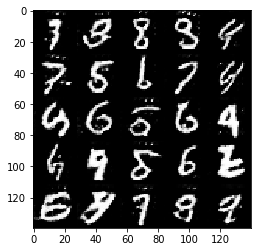

Epoch 2/2... Discriminator Loss: 0.7606... Generator Loss: 1.6181
Epoch 2/2... Discriminator Loss: 0.1430... Generator Loss: 3.2084
Epoch 2/2... Discriminator Loss: 2.2220... Generator Loss: 0.4633
Epoch 2/2... Discriminator Loss: 0.3333... Generator Loss: 1.6450
Epoch 2/2... Discriminator Loss: 0.5874... Generator Loss: 1.4934
Epoch 2/2... Discriminator Loss: 1.1035... Generator Loss: 0.6234
Epoch 2/2... Discriminator Loss: 1.1741... Generator Loss: 0.9450
Epoch 2/2... Discriminator Loss: 0.1341... Generator Loss: 2.7380
Epoch 2/2... Discriminator Loss: 1.5007... Generator Loss: 0.4249
Epoch 2/2... Discriminator Loss: 1.2042... Generator Loss: 0.6790


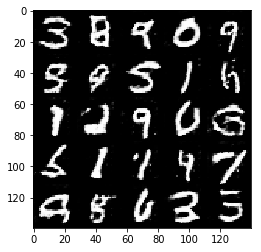

Epoch 2/2... Discriminator Loss: 0.7624... Generator Loss: 1.2404
Epoch 2/2... Discriminator Loss: 3.1209... Generator Loss: 0.0748
Epoch 2/2... Discriminator Loss: 0.2009... Generator Loss: 2.9661
Epoch 2/2... Discriminator Loss: 3.6249... Generator Loss: 0.0554
Epoch 2/2... Discriminator Loss: 0.2411... Generator Loss: 2.6817
Epoch 2/2... Discriminator Loss: 2.5110... Generator Loss: 0.3437
Epoch 2/2... Discriminator Loss: 0.1400... Generator Loss: 3.6608
Epoch 2/2... Discriminator Loss: 2.1112... Generator Loss: 0.5515
Epoch 2/2... Discriminator Loss: 0.0275... Generator Loss: 6.6881
Epoch 2/2... Discriminator Loss: 0.5542... Generator Loss: 1.6719


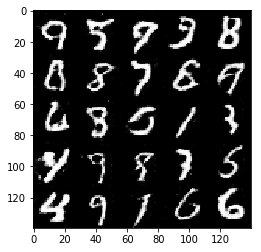

Epoch 2/2... Discriminator Loss: 2.1908... Generator Loss: 0.9699
Epoch 2/2... Discriminator Loss: 2.7942... Generator Loss: 0.1827
Epoch 2/2... Discriminator Loss: 0.1578... Generator Loss: 4.1044
Epoch 2/2... Discriminator Loss: 0.4150... Generator Loss: 1.9488
Epoch 2/2... Discriminator Loss: 0.5609... Generator Loss: 1.6325
Epoch 2/2... Discriminator Loss: 0.4737... Generator Loss: 2.2222
Epoch 2/2... Discriminator Loss: 1.0758... Generator Loss: 1.2008
Epoch 2/2... Discriminator Loss: 1.1195... Generator Loss: 0.8522
Epoch 2/2... Discriminator Loss: 0.5199... Generator Loss: 2.1821
Epoch 2/2... Discriminator Loss: 0.5161... Generator Loss: 1.3593


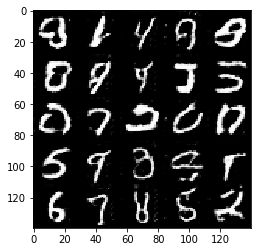

Epoch 2/2... Discriminator Loss: 0.1901... Generator Loss: 3.3782
Epoch 2/2... Discriminator Loss: 4.3848... Generator Loss: 0.0472
Epoch 2/2... Discriminator Loss: 2.1733... Generator Loss: 0.5284
Epoch 2/2... Discriminator Loss: 3.7098... Generator Loss: 0.0576
Epoch 2/2... Discriminator Loss: 0.6872... Generator Loss: 1.0717
Epoch 2/2... Discriminator Loss: 0.0662... Generator Loss: 3.9865
Epoch 2/2... Discriminator Loss: 3.9833... Generator Loss: 0.2129
Epoch 2/2... Discriminator Loss: 1.2572... Generator Loss: 1.0693
Epoch 2/2... Discriminator Loss: 0.2101... Generator Loss: 2.9272
Epoch 2/2... Discriminator Loss: 1.5821... Generator Loss: 0.4256


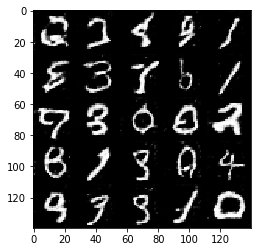

Epoch 2/2... Discriminator Loss: 0.4187... Generator Loss: 1.4284
Epoch 2/2... Discriminator Loss: 0.0766... Generator Loss: 6.3408
Epoch 2/2... Discriminator Loss: 1.2581... Generator Loss: 0.9772
Epoch 2/2... Discriminator Loss: 3.5444... Generator Loss: 0.1836
Epoch 2/2... Discriminator Loss: 1.6021... Generator Loss: 0.4599
Epoch 2/2... Discriminator Loss: 3.7736... Generator Loss: 0.0399
Epoch 2/2... Discriminator Loss: 1.9202... Generator Loss: 0.4948
Epoch 2/2... Discriminator Loss: 0.2921... Generator Loss: 1.6542
Epoch 2/2... Discriminator Loss: 0.7479... Generator Loss: 2.5161
Epoch 2/2... Discriminator Loss: 0.3105... Generator Loss: 1.9283


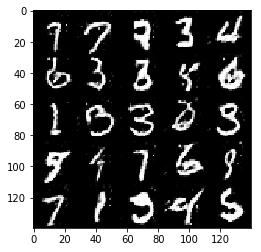

Epoch 2/2... Discriminator Loss: 2.3882... Generator Loss: 0.3430
Epoch 2/2... Discriminator Loss: 0.7192... Generator Loss: 1.3217
Epoch 2/2... Discriminator Loss: 0.3627... Generator Loss: 1.4729
Epoch 2/2... Discriminator Loss: 0.5105... Generator Loss: 13.0037
Epoch 2/2... Discriminator Loss: 1.8934... Generator Loss: 0.6717
Epoch 2/2... Discriminator Loss: 0.7970... Generator Loss: 0.8196
Epoch 2/2... Discriminator Loss: 4.0220... Generator Loss: 0.0621
Epoch 2/2... Discriminator Loss: 2.1290... Generator Loss: 0.1742
Epoch 2/2... Discriminator Loss: 0.6620... Generator Loss: 1.8930
Epoch 2/2... Discriminator Loss: 0.0904... Generator Loss: 4.7066


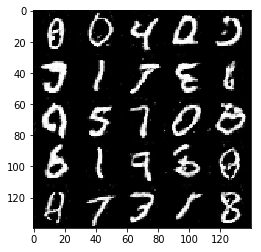

Epoch 2/2... Discriminator Loss: 0.7698... Generator Loss: 1.2624
Epoch 2/2... Discriminator Loss: 0.1498... Generator Loss: 2.6177
Epoch 2/2... Discriminator Loss: 5.7121... Generator Loss: 0.0068
Epoch 2/2... Discriminator Loss: 1.8425... Generator Loss: 0.9005
Epoch 2/2... Discriminator Loss: 1.8180... Generator Loss: 0.7025
Epoch 2/2... Discriminator Loss: 1.5675... Generator Loss: 0.5394
Epoch 2/2... Discriminator Loss: 0.2752... Generator Loss: 2.2937
Epoch 2/2... Discriminator Loss: 0.2404... Generator Loss: 2.3208
Epoch 2/2... Discriminator Loss: 0.7042... Generator Loss: 1.0735
Epoch 2/2... Discriminator Loss: 0.1141... Generator Loss: 2.9981


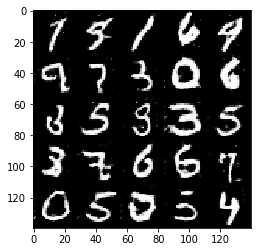

Epoch 2/2... Discriminator Loss: 1.8428... Generator Loss: 0.5168
Epoch 2/2... Discriminator Loss: 1.0953... Generator Loss: 1.3533
Epoch 2/2... Discriminator Loss: 2.8821... Generator Loss: 0.1467
Epoch 2/2... Discriminator Loss: 1.4723... Generator Loss: 0.4443
Epoch 2/2... Discriminator Loss: 0.1113... Generator Loss: 2.7804
Epoch 2/2... Discriminator Loss: 3.3626... Generator Loss: 0.2131
Epoch 2/2... Discriminator Loss: 2.2592... Generator Loss: 0.2128
Epoch 2/2... Discriminator Loss: 4.9372... Generator Loss: 0.0971
Epoch 2/2... Discriminator Loss: 0.0599... Generator Loss: 3.9812
Epoch 2/2... Discriminator Loss: 0.6951... Generator Loss: 1.2103


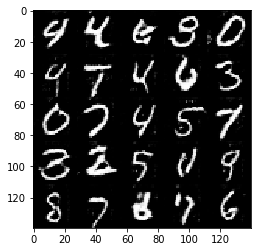

Epoch 2/2... Discriminator Loss: 1.4191... Generator Loss: 0.8230
Epoch 2/2... Discriminator Loss: 1.1767... Generator Loss: 0.7925
Epoch 2/2... Discriminator Loss: 0.1844... Generator Loss: 2.4047
Epoch 2/2... Discriminator Loss: 0.6780... Generator Loss: 1.0792
Epoch 2/2... Discriminator Loss: 0.3372... Generator Loss: 8.3428
Epoch 2/2... Discriminator Loss: 1.9395... Generator Loss: 0.2453
Epoch 2/2... Discriminator Loss: 1.9213... Generator Loss: 0.3319
Epoch 2/2... Discriminator Loss: 1.4776... Generator Loss: 0.8240
Epoch 2/2... Discriminator Loss: 1.3038... Generator Loss: 0.8497
Epoch 2/2... Discriminator Loss: 2.2286... Generator Loss: 0.3858


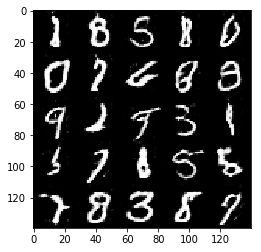

Epoch 2/2... Discriminator Loss: 1.9260... Generator Loss: 0.3929
Epoch 2/2... Discriminator Loss: 1.8108... Generator Loss: 0.4326
Epoch 2/2... Discriminator Loss: 0.6122... Generator Loss: 0.9842
Epoch 2/2... Discriminator Loss: 0.7304... Generator Loss: 0.8903
Epoch 2/2... Discriminator Loss: 0.0932... Generator Loss: 5.3338
Epoch 2/2... Discriminator Loss: 2.4590... Generator Loss: 0.1546
Epoch 2/2... Discriminator Loss: 0.5523... Generator Loss: 2.2365
Epoch 2/2... Discriminator Loss: 0.6461... Generator Loss: 1.1222
Epoch 2/2... Discriminator Loss: 0.3350... Generator Loss: 1.8038
Epoch 2/2... Discriminator Loss: 4.9273... Generator Loss: 0.0168


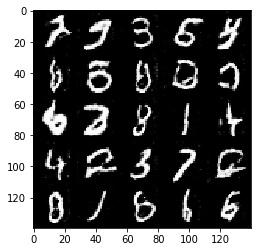

Epoch 2/2... Discriminator Loss: 0.4314... Generator Loss: 2.3110
Epoch 2/2... Discriminator Loss: 1.9672... Generator Loss: 0.5489
Epoch 2/2... Discriminator Loss: 0.6445... Generator Loss: 1.7993
Epoch 2/2... Discriminator Loss: 0.9662... Generator Loss: 0.9388
Epoch 2/2... Discriminator Loss: 0.4058... Generator Loss: 1.5392
Epoch 2/2... Discriminator Loss: 0.6188... Generator Loss: 1.6992
Epoch 2/2... Discriminator Loss: 0.5743... Generator Loss: 1.3271
Epoch 2/2... Discriminator Loss: 0.0808... Generator Loss: 8.1827
Epoch 2/2... Discriminator Loss: 0.6819... Generator Loss: 1.3674
Epoch 2/2... Discriminator Loss: 2.5720... Generator Loss: 0.2273


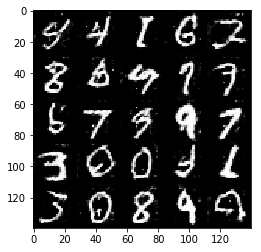

Epoch 2/2... Discriminator Loss: 0.5859... Generator Loss: 1.5031
Epoch 2/2... Discriminator Loss: 1.1754... Generator Loss: 0.6242
Epoch 2/2... Discriminator Loss: 0.1067... Generator Loss: 2.7691
Epoch 2/2... Discriminator Loss: 0.0333... Generator Loss: 4.0347
Epoch 2/2... Discriminator Loss: 0.6936... Generator Loss: 2.3255
Epoch 2/2... Discriminator Loss: 1.7456... Generator Loss: 0.5468
Epoch 2/2... Discriminator Loss: 0.4909... Generator Loss: 1.5438
Epoch 2/2... Discriminator Loss: 0.5225... Generator Loss: 1.0995
Epoch 2/2... Discriminator Loss: 0.3285... Generator Loss: 6.1967
Epoch 2/2... Discriminator Loss: 1.7281... Generator Loss: 0.2985


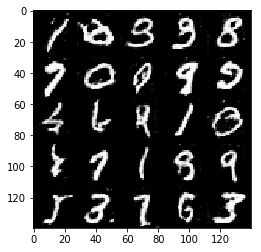

Epoch 2/2... Discriminator Loss: 0.4106... Generator Loss: 1.4924
Epoch 2/2... Discriminator Loss: 0.0315... Generator Loss: 5.2910
Epoch 2/2... Discriminator Loss: 4.6788... Generator Loss: 0.0177
Epoch 2/2... Discriminator Loss: 0.2123... Generator Loss: 2.5238
Epoch 2/2... Discriminator Loss: 0.5426... Generator Loss: 1.2485
Epoch 2/2... Discriminator Loss: 0.9881... Generator Loss: 0.6636
Epoch 2/2... Discriminator Loss: 0.8489... Generator Loss: 1.3162
Epoch 2/2... Discriminator Loss: 0.6769... Generator Loss: 1.2519
Epoch 2/2... Discriminator Loss: 0.2595... Generator Loss: 2.4400
Epoch 2/2... Discriminator Loss: 1.8851... Generator Loss: 0.4391


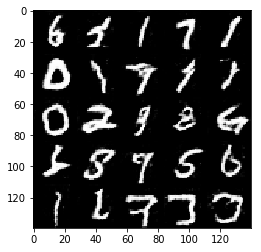

Epoch 2/2... Discriminator Loss: 3.5596... Generator Loss: 0.0577
Epoch 2/2... Discriminator Loss: 0.5793... Generator Loss: 2.0418
Epoch 2/2... Discriminator Loss: 1.0832... Generator Loss: 0.9737
Epoch 2/2... Discriminator Loss: 1.6202... Generator Loss: 0.6657
Epoch 2/2... Discriminator Loss: 1.4861... Generator Loss: 0.7930
Epoch 2/2... Discriminator Loss: 0.8496... Generator Loss: 0.7551
Epoch 2/2... Discriminator Loss: 0.2557... Generator Loss: 2.8300
Epoch 2/2... Discriminator Loss: 2.4854... Generator Loss: 0.2955
Epoch 2/2... Discriminator Loss: 0.1002... Generator Loss: 5.2900
Epoch 2/2... Discriminator Loss: 1.3573... Generator Loss: 0.7807


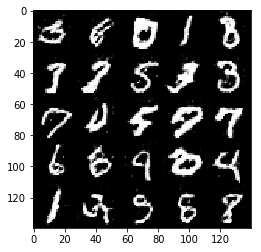

Epoch 2/2... Discriminator Loss: 1.4281... Generator Loss: 0.5689
Epoch 2/2... Discriminator Loss: 0.3621... Generator Loss: 1.6631
Epoch 2/2... Discriminator Loss: 0.0711... Generator Loss: 3.4277
Epoch 2/2... Discriminator Loss: 1.8582... Generator Loss: 0.5244
Epoch 2/2... Discriminator Loss: 0.2234... Generator Loss: 3.8647
Epoch 2/2... Discriminator Loss: 1.3730... Generator Loss: 0.8267
Epoch 2/2... Discriminator Loss: 0.8030... Generator Loss: 1.2881
Epoch 2/2... Discriminator Loss: 0.4850... Generator Loss: 1.3431
Epoch 2/2... Discriminator Loss: 0.7645... Generator Loss: 1.7363
Epoch 2/2... Discriminator Loss: 0.1521... Generator Loss: 5.3745


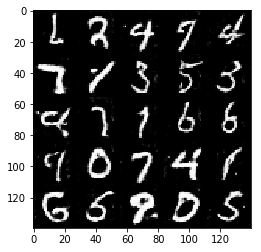

Epoch 2/2... Discriminator Loss: 1.0885... Generator Loss: 0.6635
Epoch 2/2... Discriminator Loss: 1.8737... Generator Loss: 0.7704
Epoch 2/2... Discriminator Loss: 1.2395... Generator Loss: 1.3049
Epoch 2/2... Discriminator Loss: 0.0119... Generator Loss: 6.2925
Epoch 2/2... Discriminator Loss: 0.1945... Generator Loss: 2.7574
Epoch 2/2... Discriminator Loss: 1.6516... Generator Loss: 0.7186
Epoch 2/2... Discriminator Loss: 0.1554... Generator Loss: 2.9323
Epoch 2/2... Discriminator Loss: 0.3823... Generator Loss: 2.2166
Epoch 2/2... Discriminator Loss: 0.8716... Generator Loss: 0.7902
Epoch 2/2... Discriminator Loss: 1.7954... Generator Loss: 0.3607


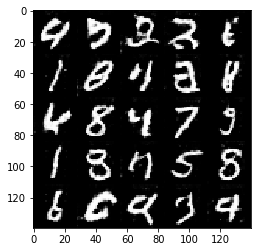

Epoch 2/2... Discriminator Loss: 0.1660... Generator Loss: 6.7409
Epoch 2/2... Discriminator Loss: 1.3779... Generator Loss: 0.8201
Epoch 2/2... Discriminator Loss: 2.3508... Generator Loss: 6.1108
Epoch 2/2... Discriminator Loss: 0.3435... Generator Loss: 2.3078
Epoch 2/2... Discriminator Loss: 1.9293... Generator Loss: 0.3892
Epoch 2/2... Discriminator Loss: 0.0429... Generator Loss: 4.7553
Epoch 2/2... Discriminator Loss: 1.4395... Generator Loss: 1.5560
Epoch 2/2... Discriminator Loss: 1.2112... Generator Loss: 0.6206
Epoch 2/2... Discriminator Loss: 1.0092... Generator Loss: 1.4601
Epoch 2/2... Discriminator Loss: 1.1380... Generator Loss: 0.7172


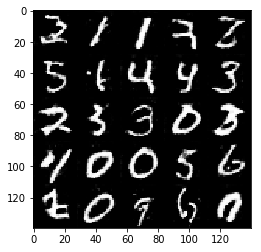

Epoch 2/2... Discriminator Loss: 0.3605... Generator Loss: 1.9925
Epoch 2/2... Discriminator Loss: 1.2652... Generator Loss: 0.7386
Epoch 2/2... Discriminator Loss: 0.7108... Generator Loss: 1.0193
Epoch 2/2... Discriminator Loss: 2.1864... Generator Loss: 0.2117
Epoch 2/2... Discriminator Loss: 1.7718... Generator Loss: 0.5612
Epoch 2/2... Discriminator Loss: 1.0004... Generator Loss: 0.9954
Epoch 2/2... Discriminator Loss: 0.4239... Generator Loss: 1.9499
Epoch 2/2... Discriminator Loss: 1.4224... Generator Loss: 0.5629
Epoch 2/2... Discriminator Loss: 0.2467... Generator Loss: 4.9186
Epoch 2/2... Discriminator Loss: 0.0154... Generator Loss: 8.1082


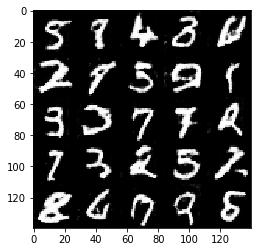

Epoch 2/2... Discriminator Loss: 3.3537... Generator Loss: 0.2597
Epoch 2/2... Discriminator Loss: 3.1776... Generator Loss: 0.4961
Epoch 2/2... Discriminator Loss: 1.2064... Generator Loss: 1.2402
Epoch 2/2... Discriminator Loss: 2.5619... Generator Loss: 0.2947
Epoch 2/2... Discriminator Loss: 3.7287... Generator Loss: 0.0788
Epoch 2/2... Discriminator Loss: 0.2949... Generator Loss: 3.0221
Epoch 2/2... Discriminator Loss: 1.9854... Generator Loss: 0.4485
Epoch 2/2... Discriminator Loss: 0.9466... Generator Loss: 0.9111
Epoch 2/2... Discriminator Loss: 1.0198... Generator Loss: 9.7948
Epoch 2/2... Discriminator Loss: 0.6282... Generator Loss: 1.7239


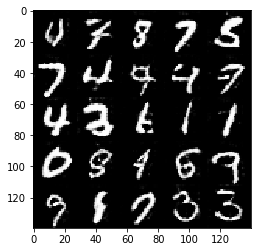

Epoch 2/2... Discriminator Loss: 0.8374... Generator Loss: 1.2950
Epoch 2/2... Discriminator Loss: 1.9047... Generator Loss: 0.3610
Epoch 2/2... Discriminator Loss: 1.8626... Generator Loss: 0.4481
Epoch 2/2... Discriminator Loss: 3.3144... Generator Loss: 0.3091
Epoch 2/2... Discriminator Loss: 1.8047... Generator Loss: 0.2997
Epoch 2/2... Discriminator Loss: 0.7643... Generator Loss: 1.0149
Epoch 2/2... Discriminator Loss: 0.2522... Generator Loss: 3.3148
Epoch 2/2... Discriminator Loss: 1.4352... Generator Loss: 0.5217
Epoch 2/2... Discriminator Loss: 1.3315... Generator Loss: 8.9422
Epoch 2/2... Discriminator Loss: 0.6206... Generator Loss: 1.2050


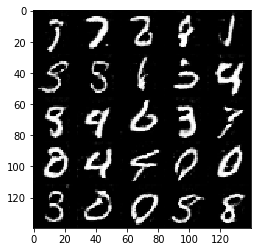

Epoch 2/2... Discriminator Loss: 1.9121... Generator Loss: 0.2810
Epoch 2/2... Discriminator Loss: 1.7068... Generator Loss: 7.1219
Epoch 2/2... Discriminator Loss: 1.1571... Generator Loss: 0.8617
Epoch 2/2... Discriminator Loss: 2.4404... Generator Loss: 0.1627
Epoch 2/2... Discriminator Loss: 1.5179... Generator Loss: 0.9991
Epoch 2/2... Discriminator Loss: 0.1388... Generator Loss: 3.7571
Epoch 2/2... Discriminator Loss: 3.9519... Generator Loss: 8.3267
Epoch 2/2... Discriminator Loss: 0.4927... Generator Loss: 2.2875
Epoch 2/2... Discriminator Loss: 0.6731... Generator Loss: 1.5756
Epoch 2/2... Discriminator Loss: 2.9778... Generator Loss: 0.2185


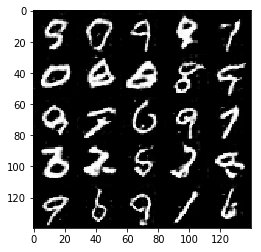

Epoch 2/2... Discriminator Loss: 1.1172... Generator Loss: 1.3709
Epoch 2/2... Discriminator Loss: 1.1198... Generator Loss: 0.5011
Epoch 2/2... Discriminator Loss: 1.6540... Generator Loss: 0.5584
Epoch 2/2... Discriminator Loss: 2.3192... Generator Loss: 0.2023
Epoch 2/2... Discriminator Loss: 0.5584... Generator Loss: 1.4172
Epoch 2/2... Discriminator Loss: 1.1249... Generator Loss: 0.9676
Epoch 2/2... Discriminator Loss: 0.0673... Generator Loss: 4.1913
Epoch 2/2... Discriminator Loss: 2.0012... Generator Loss: 0.3368
Epoch 2/2... Discriminator Loss: 1.6160... Generator Loss: 0.8066
Epoch 2/2... Discriminator Loss: 0.8498... Generator Loss: 0.9257


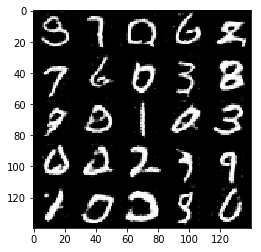

Epoch 2/2... Discriminator Loss: 1.8534... Generator Loss: 0.2937
Epoch 2/2... Discriminator Loss: 1.3060... Generator Loss: 0.6232
Epoch 2/2... Discriminator Loss: 0.1266... Generator Loss: 2.8918
Epoch 2/2... Discriminator Loss: 0.1111... Generator Loss: 3.4547
Epoch 2/2... Discriminator Loss: 0.2549... Generator Loss: 2.5017
Epoch 2/2... Discriminator Loss: 0.0866... Generator Loss: 6.3202
Epoch 2/2... Discriminator Loss: 0.0123... Generator Loss: 6.1852
Epoch 2/2... Discriminator Loss: 0.5002... Generator Loss: 2.8360
Epoch 2/2... Discriminator Loss: 0.1135... Generator Loss: 2.9252
Epoch 2/2... Discriminator Loss: 0.1907... Generator Loss: 2.6558


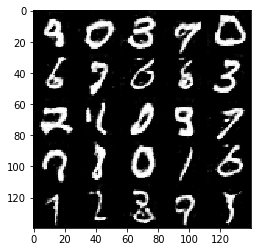

Epoch 2/2... Discriminator Loss: 1.4138... Generator Loss: 0.5751
Epoch 2/2... Discriminator Loss: 0.8573... Generator Loss: 1.4396
Epoch 2/2... Discriminator Loss: 3.1873... Generator Loss: 0.2682
Epoch 2/2... Discriminator Loss: 0.4247... Generator Loss: 1.7294
Epoch 2/2... Discriminator Loss: 0.9487... Generator Loss: 1.1705
Epoch 2/2... Discriminator Loss: 0.6832... Generator Loss: 1.4252
Epoch 2/2... Discriminator Loss: 3.5579... Generator Loss: 0.3067
Epoch 2/2... Discriminator Loss: 0.2998... Generator Loss: 5.3886
Epoch 2/2... Discriminator Loss: 0.4173... Generator Loss: 2.2124
Epoch 2/2... Discriminator Loss: 1.1671... Generator Loss: 0.7176


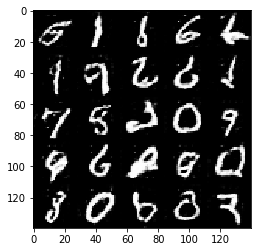

Epoch 2/2... Discriminator Loss: 1.8900... Generator Loss: 0.4680
Epoch 2/2... Discriminator Loss: 0.3235... Generator Loss: 3.5682
Epoch 2/2... Discriminator Loss: 0.7531... Generator Loss: 1.1860
Epoch 2/2... Discriminator Loss: 0.3783... Generator Loss: 3.8765
Epoch 2/2... Discriminator Loss: 3.6614... Generator Loss: 0.2391
Epoch 2/2... Discriminator Loss: 0.6164... Generator Loss: 1.4952
Epoch 2/2... Discriminator Loss: 1.8426... Generator Loss: 0.3915
Epoch 2/2... Discriminator Loss: 0.1140... Generator Loss: 2.5484
Epoch 2/2... Discriminator Loss: 2.4739... Generator Loss: 0.1504
Epoch 2/2... Discriminator Loss: 2.1706... Generator Loss: 0.6269


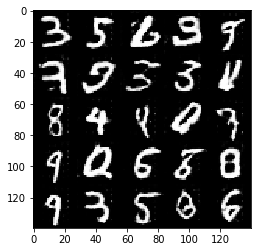

Epoch 2/2... Discriminator Loss: 1.8444... Generator Loss: 0.9924
Epoch 2/2... Discriminator Loss: 1.2622... Generator Loss: 0.6298
Epoch 2/2... Discriminator Loss: 3.6794... Generator Loss: 0.0744
Epoch 2/2... Discriminator Loss: 1.8217... Generator Loss: 0.7335
Epoch 2/2... Discriminator Loss: 1.4267... Generator Loss: 0.8283
Epoch 2/2... Discriminator Loss: 2.2565... Generator Loss: 0.3555
Epoch 2/2... Discriminator Loss: 0.1676... Generator Loss: 4.1029
Epoch 2/2... Discriminator Loss: 1.4527... Generator Loss: 1.0304
Epoch 2/2... Discriminator Loss: 1.6680... Generator Loss: 0.8682
Epoch 2/2... Discriminator Loss: 2.0739... Generator Loss: 0.2726


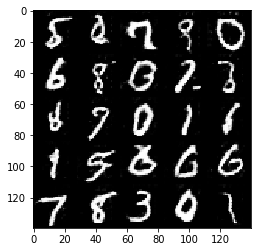

Epoch 2/2... Discriminator Loss: 0.1042... Generator Loss: 2.9240
Epoch 2/2... Discriminator Loss: 0.5615... Generator Loss: 1.4672
Epoch 2/2... Discriminator Loss: 0.0479... Generator Loss: 8.2843
Epoch 2/2... Discriminator Loss: 2.5856... Generator Loss: 0.1602
Epoch 2/2... Discriminator Loss: 0.1868... Generator Loss: 2.7300
Epoch 2/2... Discriminator Loss: 1.0222... Generator Loss: 1.1207
Epoch 2/2... Discriminator Loss: 0.1188... Generator Loss: 4.1152
Epoch 2/2... Discriminator Loss: 0.2911... Generator Loss: 2.7739
Epoch 2/2... Discriminator Loss: 1.1422... Generator Loss: 0.7604
Epoch 2/2... Discriminator Loss: 1.2437... Generator Loss: 0.4744


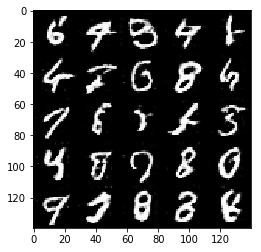

Epoch 2/2... Discriminator Loss: 0.9636... Generator Loss: 1.1209
Epoch 2/2... Discriminator Loss: 0.1942... Generator Loss: 2.6858
Epoch 2/2... Discriminator Loss: 1.4216... Generator Loss: 0.4570
Epoch 2/2... Discriminator Loss: 3.2926... Generator Loss: 0.1010
Epoch 2/2... Discriminator Loss: 3.1574... Generator Loss: 8.8527
Epoch 2/2... Discriminator Loss: 0.4037... Generator Loss: 1.7117
Epoch 2/2... Discriminator Loss: 0.2378... Generator Loss: 2.4971
Epoch 2/2... Discriminator Loss: 1.1181... Generator Loss: 1.1191
Epoch 2/2... Discriminator Loss: 1.5557... Generator Loss: 0.5187
Epoch 2/2... Discriminator Loss: 0.2076... Generator Loss: 2.7518


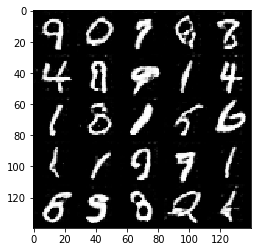

Epoch 2/2... Discriminator Loss: 0.3580... Generator Loss: 1.8772
Epoch 2/2... Discriminator Loss: 1.2293... Generator Loss: 1.2172
Epoch 2/2... Discriminator Loss: 0.9210... Generator Loss: 1.6528
Epoch 2/2... Discriminator Loss: 1.7387... Generator Loss: 0.5208
Epoch 2/2... Discriminator Loss: 0.5638... Generator Loss: 9.3280
Epoch 2/2... Discriminator Loss: 0.5273... Generator Loss: 1.9441
Epoch 2/2... Discriminator Loss: 0.1239... Generator Loss: 3.5348
Epoch 2/2... Discriminator Loss: 3.9382... Generator Loss: 0.2037
Epoch 2/2... Discriminator Loss: 1.4967... Generator Loss: 0.7428
Epoch 2/2... Discriminator Loss: 1.0808... Generator Loss: 1.8309


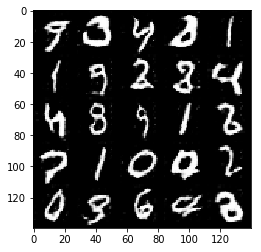

Epoch 2/2... Discriminator Loss: 0.7508... Generator Loss: 1.6013
Epoch 2/2... Discriminator Loss: 0.2243... Generator Loss: 2.4689
Epoch 2/2... Discriminator Loss: 0.4168... Generator Loss: 1.3634
Epoch 2/2... Discriminator Loss: 0.2033... Generator Loss: 2.1144
Epoch 2/2... Discriminator Loss: 2.3837... Generator Loss: 0.2169
Epoch 2/2... Discriminator Loss: 0.2916... Generator Loss: 1.6024
Epoch 2/2... Discriminator Loss: 1.9588... Generator Loss: 0.4253
Epoch 2/2... Discriminator Loss: 2.4658... Generator Loss: 0.1358
Epoch 2/2... Discriminator Loss: 2.1722... Generator Loss: 0.3661
Epoch 2/2... Discriminator Loss: 0.4117... Generator Loss: 1.7298


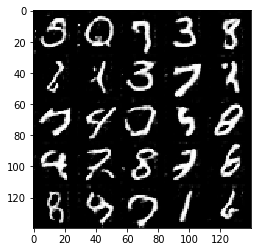

In [12]:
batch_size = 10
z_dim = 100
learning_rate = 0.0003
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 1.0788... Generator Loss: 21.8080
Epoch 1/1... Discriminator Loss: 12.7006... Generator Loss: 0.0009
Epoch 1/1... Discriminator Loss: 1.2199... Generator Loss: 12.2535
Epoch 1/1... Discriminator Loss: 0.1721... Generator Loss: 4.9132
Epoch 1/1... Discriminator Loss: 0.2801... Generator Loss: 6.3038
Epoch 1/1... Discriminator Loss: 1.3578... Generator Loss: 0.8789
Epoch 1/1... Discriminator Loss: 2.4663... Generator Loss: 0.2799
Epoch 1/1... Discriminator Loss: 1.1515... Generator Loss: 0.7491
Epoch 1/1... Discriminator Loss: 1.2656... Generator Loss: 0.4910
Epoch 1/1... Discriminator Loss: 1.3215... Generator Loss: 0.4794


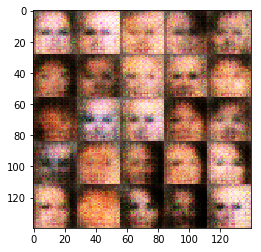

Epoch 1/1... Discriminator Loss: 0.3652... Generator Loss: 2.8972
Epoch 1/1... Discriminator Loss: 0.5487... Generator Loss: 2.5317
Epoch 1/1... Discriminator Loss: 2.0149... Generator Loss: 0.2606
Epoch 1/1... Discriminator Loss: 0.9780... Generator Loss: 2.9058
Epoch 1/1... Discriminator Loss: 0.5034... Generator Loss: 1.9461
Epoch 1/1... Discriminator Loss: 0.5018... Generator Loss: 1.5629
Epoch 1/1... Discriminator Loss: 1.1922... Generator Loss: 0.7323
Epoch 1/1... Discriminator Loss: 1.1484... Generator Loss: 2.1604
Epoch 1/1... Discriminator Loss: 0.7687... Generator Loss: 2.6676
Epoch 1/1... Discriminator Loss: 0.8707... Generator Loss: 1.6447


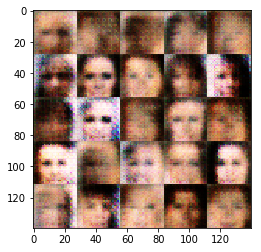

Epoch 1/1... Discriminator Loss: 0.8858... Generator Loss: 1.5625
Epoch 1/1... Discriminator Loss: 1.1251... Generator Loss: 0.7745
Epoch 1/1... Discriminator Loss: 1.7697... Generator Loss: 0.2721
Epoch 1/1... Discriminator Loss: 0.7006... Generator Loss: 1.0992
Epoch 1/1... Discriminator Loss: 1.0858... Generator Loss: 2.0961
Epoch 1/1... Discriminator Loss: 1.1486... Generator Loss: 1.5489
Epoch 1/1... Discriminator Loss: 1.0816... Generator Loss: 1.2535
Epoch 1/1... Discriminator Loss: 1.2089... Generator Loss: 2.4144
Epoch 1/1... Discriminator Loss: 2.5334... Generator Loss: 4.0012
Epoch 1/1... Discriminator Loss: 1.0673... Generator Loss: 2.0365


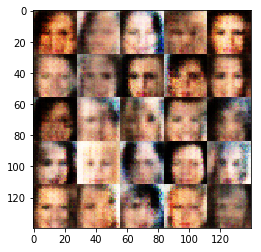

Epoch 1/1... Discriminator Loss: 1.1756... Generator Loss: 0.6422
Epoch 1/1... Discriminator Loss: 1.2982... Generator Loss: 1.8759
Epoch 1/1... Discriminator Loss: 1.0397... Generator Loss: 1.0036
Epoch 1/1... Discriminator Loss: 1.3408... Generator Loss: 0.4783
Epoch 1/1... Discriminator Loss: 1.1164... Generator Loss: 0.9527
Epoch 1/1... Discriminator Loss: 1.0908... Generator Loss: 0.7096
Epoch 1/1... Discriminator Loss: 1.1537... Generator Loss: 1.7766
Epoch 1/1... Discriminator Loss: 1.8873... Generator Loss: 0.2319
Epoch 1/1... Discriminator Loss: 2.1132... Generator Loss: 0.2619
Epoch 1/1... Discriminator Loss: 1.1411... Generator Loss: 0.8114


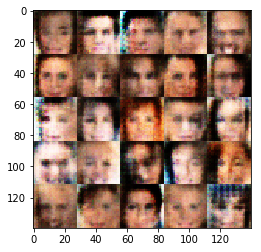

Epoch 1/1... Discriminator Loss: 1.8792... Generator Loss: 0.3158
Epoch 1/1... Discriminator Loss: 0.8161... Generator Loss: 1.0620
Epoch 1/1... Discriminator Loss: 1.9742... Generator Loss: 4.2473
Epoch 1/1... Discriminator Loss: 1.5211... Generator Loss: 2.4320
Epoch 1/1... Discriminator Loss: 0.7854... Generator Loss: 1.6485
Epoch 1/1... Discriminator Loss: 3.7174... Generator Loss: 5.0992
Epoch 1/1... Discriminator Loss: 1.1567... Generator Loss: 0.8464
Epoch 1/1... Discriminator Loss: 1.1772... Generator Loss: 0.5290
Epoch 1/1... Discriminator Loss: 2.3330... Generator Loss: 0.1814
Epoch 1/1... Discriminator Loss: 0.8769... Generator Loss: 1.1755


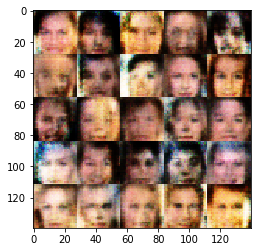

Epoch 1/1... Discriminator Loss: 1.1008... Generator Loss: 0.6651
Epoch 1/1... Discriminator Loss: 1.0190... Generator Loss: 1.5427
Epoch 1/1... Discriminator Loss: 1.9336... Generator Loss: 0.2593
Epoch 1/1... Discriminator Loss: 0.9581... Generator Loss: 1.2742
Epoch 1/1... Discriminator Loss: 0.9805... Generator Loss: 0.7410
Epoch 1/1... Discriminator Loss: 2.0750... Generator Loss: 0.1793
Epoch 1/1... Discriminator Loss: 0.9537... Generator Loss: 1.0433
Epoch 1/1... Discriminator Loss: 1.2305... Generator Loss: 0.5118
Epoch 1/1... Discriminator Loss: 0.8311... Generator Loss: 1.7675
Epoch 1/1... Discriminator Loss: 1.3653... Generator Loss: 2.2832


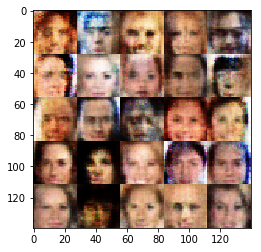

Epoch 1/1... Discriminator Loss: 1.6739... Generator Loss: 0.2971
Epoch 1/1... Discriminator Loss: 0.9876... Generator Loss: 0.7878
Epoch 1/1... Discriminator Loss: 1.2778... Generator Loss: 1.2937
Epoch 1/1... Discriminator Loss: 2.4548... Generator Loss: 3.4686
Epoch 1/1... Discriminator Loss: 0.9742... Generator Loss: 0.9132
Epoch 1/1... Discriminator Loss: 1.0881... Generator Loss: 0.5702
Epoch 1/1... Discriminator Loss: 1.8165... Generator Loss: 0.2544
Epoch 1/1... Discriminator Loss: 1.7946... Generator Loss: 0.2401
Epoch 1/1... Discriminator Loss: 0.8081... Generator Loss: 1.3029
Epoch 1/1... Discriminator Loss: 1.2425... Generator Loss: 0.8190


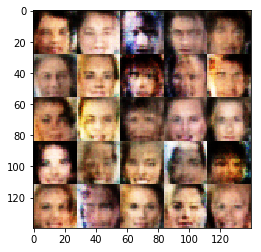

Epoch 1/1... Discriminator Loss: 0.9839... Generator Loss: 1.7435
Epoch 1/1... Discriminator Loss: 1.3420... Generator Loss: 0.4408
Epoch 1/1... Discriminator Loss: 0.9540... Generator Loss: 1.3728
Epoch 1/1... Discriminator Loss: 1.2491... Generator Loss: 0.5355
Epoch 1/1... Discriminator Loss: 1.7922... Generator Loss: 0.2589
Epoch 1/1... Discriminator Loss: 1.1977... Generator Loss: 0.6126
Epoch 1/1... Discriminator Loss: 0.8696... Generator Loss: 1.2131
Epoch 1/1... Discriminator Loss: 1.0571... Generator Loss: 1.3951
Epoch 1/1... Discriminator Loss: 1.0626... Generator Loss: 0.7478
Epoch 1/1... Discriminator Loss: 1.4128... Generator Loss: 2.6768


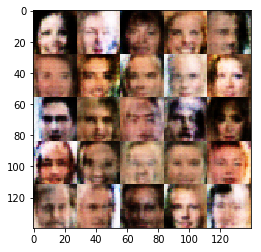

Epoch 1/1... Discriminator Loss: 1.9699... Generator Loss: 0.2796
Epoch 1/1... Discriminator Loss: 1.2441... Generator Loss: 0.4729
Epoch 1/1... Discriminator Loss: 1.3932... Generator Loss: 0.4813
Epoch 1/1... Discriminator Loss: 1.2811... Generator Loss: 0.4712
Epoch 1/1... Discriminator Loss: 1.2972... Generator Loss: 2.1115
Epoch 1/1... Discriminator Loss: 1.7005... Generator Loss: 2.4444
Epoch 1/1... Discriminator Loss: 0.8861... Generator Loss: 0.7793
Epoch 1/1... Discriminator Loss: 1.2381... Generator Loss: 1.7027
Epoch 1/1... Discriminator Loss: 1.5401... Generator Loss: 1.9424
Epoch 1/1... Discriminator Loss: 0.6492... Generator Loss: 1.5457


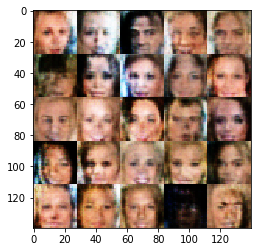

Epoch 1/1... Discriminator Loss: 1.3914... Generator Loss: 1.5772
Epoch 1/1... Discriminator Loss: 1.2803... Generator Loss: 0.4708
Epoch 1/1... Discriminator Loss: 1.7106... Generator Loss: 0.2792
Epoch 1/1... Discriminator Loss: 1.5361... Generator Loss: 0.3278
Epoch 1/1... Discriminator Loss: 1.2210... Generator Loss: 0.5513
Epoch 1/1... Discriminator Loss: 1.4928... Generator Loss: 0.4060
Epoch 1/1... Discriminator Loss: 1.5577... Generator Loss: 0.3729
Epoch 1/1... Discriminator Loss: 2.1798... Generator Loss: 0.1975
Epoch 1/1... Discriminator Loss: 1.1400... Generator Loss: 1.8989
Epoch 1/1... Discriminator Loss: 0.8478... Generator Loss: 0.8608


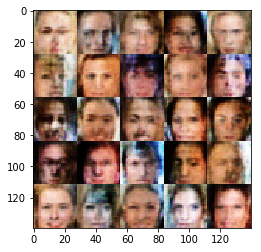

Epoch 1/1... Discriminator Loss: 1.1781... Generator Loss: 0.5525
Epoch 1/1... Discriminator Loss: 0.8157... Generator Loss: 0.9998
Epoch 1/1... Discriminator Loss: 0.9840... Generator Loss: 1.2858
Epoch 1/1... Discriminator Loss: 1.0066... Generator Loss: 1.7568
Epoch 1/1... Discriminator Loss: 1.3549... Generator Loss: 0.5016
Epoch 1/1... Discriminator Loss: 1.3556... Generator Loss: 0.4515
Epoch 1/1... Discriminator Loss: 1.0705... Generator Loss: 0.6373
Epoch 1/1... Discriminator Loss: 1.7564... Generator Loss: 2.8736
Epoch 1/1... Discriminator Loss: 0.9800... Generator Loss: 0.8041
Epoch 1/1... Discriminator Loss: 0.7988... Generator Loss: 1.9311


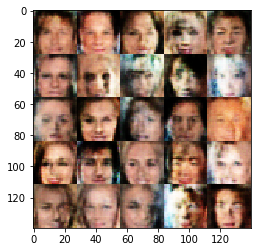

Epoch 1/1... Discriminator Loss: 0.6970... Generator Loss: 1.0589
Epoch 1/1... Discriminator Loss: 1.1391... Generator Loss: 0.5079
Epoch 1/1... Discriminator Loss: 0.6214... Generator Loss: 2.7325
Epoch 1/1... Discriminator Loss: 1.6958... Generator Loss: 2.6678
Epoch 1/1... Discriminator Loss: 0.6738... Generator Loss: 1.1530
Epoch 1/1... Discriminator Loss: 0.7824... Generator Loss: 0.9416
Epoch 1/1... Discriminator Loss: 1.5494... Generator Loss: 0.3482
Epoch 1/1... Discriminator Loss: 2.1090... Generator Loss: 0.2281
Epoch 1/1... Discriminator Loss: 1.3783... Generator Loss: 3.1048
Epoch 1/1... Discriminator Loss: 1.2157... Generator Loss: 0.5101


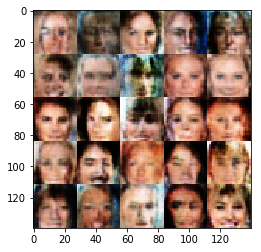

Epoch 1/1... Discriminator Loss: 0.2587... Generator Loss: 2.3252
Epoch 1/1... Discriminator Loss: 1.4475... Generator Loss: 1.5944
Epoch 1/1... Discriminator Loss: 1.2063... Generator Loss: 0.4835
Epoch 1/1... Discriminator Loss: 0.4298... Generator Loss: 2.0251
Epoch 1/1... Discriminator Loss: 1.0752... Generator Loss: 0.6391
Epoch 1/1... Discriminator Loss: 0.4994... Generator Loss: 1.4619
Epoch 1/1... Discriminator Loss: 1.2313... Generator Loss: 3.6152
Epoch 1/1... Discriminator Loss: 0.3621... Generator Loss: 1.6503
Epoch 1/1... Discriminator Loss: 3.1108... Generator Loss: 0.1187
Epoch 1/1... Discriminator Loss: 1.0945... Generator Loss: 0.8238


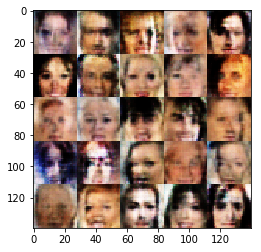

Epoch 1/1... Discriminator Loss: 0.9569... Generator Loss: 1.1131
Epoch 1/1... Discriminator Loss: 0.5612... Generator Loss: 1.9383
Epoch 1/1... Discriminator Loss: 0.8020... Generator Loss: 0.9442
Epoch 1/1... Discriminator Loss: 0.9085... Generator Loss: 2.5014
Epoch 1/1... Discriminator Loss: 0.6401... Generator Loss: 1.4232
Epoch 1/1... Discriminator Loss: 0.3900... Generator Loss: 2.4924
Epoch 1/1... Discriminator Loss: 0.3594... Generator Loss: 2.5280
Epoch 1/1... Discriminator Loss: 0.6685... Generator Loss: 0.9297
Epoch 1/1... Discriminator Loss: 1.2978... Generator Loss: 0.6511
Epoch 1/1... Discriminator Loss: 0.9496... Generator Loss: 1.4255


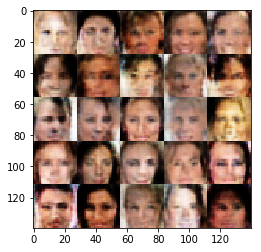

Epoch 1/1... Discriminator Loss: 0.7534... Generator Loss: 1.2158
Epoch 1/1... Discriminator Loss: 0.6297... Generator Loss: 1.5815
Epoch 1/1... Discriminator Loss: 0.6651... Generator Loss: 2.6062
Epoch 1/1... Discriminator Loss: 0.8620... Generator Loss: 2.4446
Epoch 1/1... Discriminator Loss: 1.8517... Generator Loss: 0.3057
Epoch 1/1... Discriminator Loss: 0.5228... Generator Loss: 3.4871
Epoch 1/1... Discriminator Loss: 0.2904... Generator Loss: 2.5481
Epoch 1/1... Discriminator Loss: 0.9608... Generator Loss: 0.8528
Epoch 1/1... Discriminator Loss: 1.8591... Generator Loss: 0.2572
Epoch 1/1... Discriminator Loss: 2.0979... Generator Loss: 0.1830


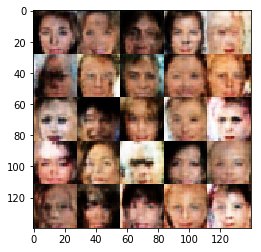

Epoch 1/1... Discriminator Loss: 0.4354... Generator Loss: 1.7701
Epoch 1/1... Discriminator Loss: 1.6361... Generator Loss: 0.3484
Epoch 1/1... Discriminator Loss: 1.0374... Generator Loss: 3.2440
Epoch 1/1... Discriminator Loss: 1.5975... Generator Loss: 0.4720
Epoch 1/1... Discriminator Loss: 2.8475... Generator Loss: 4.2792
Epoch 1/1... Discriminator Loss: 0.9559... Generator Loss: 0.9369
Epoch 1/1... Discriminator Loss: 1.0666... Generator Loss: 0.7295
Epoch 1/1... Discriminator Loss: 1.0878... Generator Loss: 0.6057
Epoch 1/1... Discriminator Loss: 1.2504... Generator Loss: 0.5832
Epoch 1/1... Discriminator Loss: 2.2449... Generator Loss: 3.7276


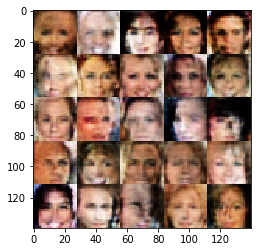

Epoch 1/1... Discriminator Loss: 1.3766... Generator Loss: 1.1964
Epoch 1/1... Discriminator Loss: 0.7918... Generator Loss: 1.1992
Epoch 1/1... Discriminator Loss: 1.4973... Generator Loss: 3.3384
Epoch 1/1... Discriminator Loss: 1.5737... Generator Loss: 0.3585
Epoch 1/1... Discriminator Loss: 1.5879... Generator Loss: 0.4237
Epoch 1/1... Discriminator Loss: 0.9175... Generator Loss: 0.8404
Epoch 1/1... Discriminator Loss: 0.7433... Generator Loss: 1.4572
Epoch 1/1... Discriminator Loss: 0.5796... Generator Loss: 1.3881
Epoch 1/1... Discriminator Loss: 0.6048... Generator Loss: 1.3246
Epoch 1/1... Discriminator Loss: 0.6152... Generator Loss: 1.3071


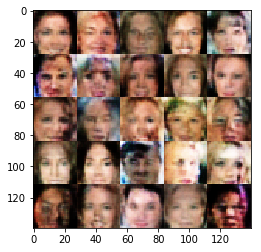

Epoch 1/1... Discriminator Loss: 0.5142... Generator Loss: 1.9247
Epoch 1/1... Discriminator Loss: 0.7489... Generator Loss: 1.2098
Epoch 1/1... Discriminator Loss: 0.7559... Generator Loss: 1.0146
Epoch 1/1... Discriminator Loss: 1.3053... Generator Loss: 0.4972
Epoch 1/1... Discriminator Loss: 1.9780... Generator Loss: 0.2514
Epoch 1/1... Discriminator Loss: 1.1597... Generator Loss: 2.3415
Epoch 1/1... Discriminator Loss: 1.8241... Generator Loss: 0.2719
Epoch 1/1... Discriminator Loss: 0.6228... Generator Loss: 2.9079
Epoch 1/1... Discriminator Loss: 0.5952... Generator Loss: 2.4947
Epoch 1/1... Discriminator Loss: 0.9879... Generator Loss: 0.7041


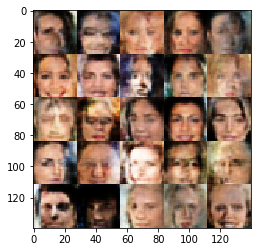

Epoch 1/1... Discriminator Loss: 0.7107... Generator Loss: 1.2629
Epoch 1/1... Discriminator Loss: 0.7998... Generator Loss: 1.0095
Epoch 1/1... Discriminator Loss: 1.1044... Generator Loss: 4.0571
Epoch 1/1... Discriminator Loss: 0.4639... Generator Loss: 1.6143
Epoch 1/1... Discriminator Loss: 0.8278... Generator Loss: 0.8905
Epoch 1/1... Discriminator Loss: 1.0433... Generator Loss: 0.7630
Epoch 1/1... Discriminator Loss: 1.2280... Generator Loss: 0.9444
Epoch 1/1... Discriminator Loss: 1.5243... Generator Loss: 0.3741
Epoch 1/1... Discriminator Loss: 0.9424... Generator Loss: 1.6101
Epoch 1/1... Discriminator Loss: 0.5732... Generator Loss: 1.5957


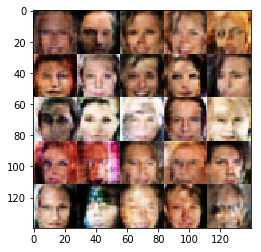

Epoch 1/1... Discriminator Loss: 0.5844... Generator Loss: 1.6591
Epoch 1/1... Discriminator Loss: 1.9510... Generator Loss: 0.2799
Epoch 1/1... Discriminator Loss: 0.8910... Generator Loss: 0.8291
Epoch 1/1... Discriminator Loss: 0.6260... Generator Loss: 3.0198
Epoch 1/1... Discriminator Loss: 0.6833... Generator Loss: 1.1662
Epoch 1/1... Discriminator Loss: 0.4256... Generator Loss: 1.8332
Epoch 1/1... Discriminator Loss: 1.0306... Generator Loss: 3.3741
Epoch 1/1... Discriminator Loss: 0.6677... Generator Loss: 1.1442
Epoch 1/1... Discriminator Loss: 2.3712... Generator Loss: 0.1482
Epoch 1/1... Discriminator Loss: 0.5285... Generator Loss: 1.7207


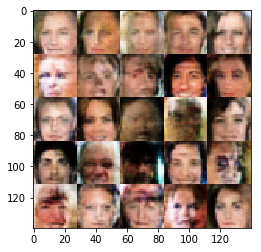

Epoch 1/1... Discriminator Loss: 0.5957... Generator Loss: 1.3636
Epoch 1/1... Discriminator Loss: 0.4615... Generator Loss: 2.0213
Epoch 1/1... Discriminator Loss: 2.0532... Generator Loss: 0.2865
Epoch 1/1... Discriminator Loss: 0.4937... Generator Loss: 2.3531
Epoch 1/1... Discriminator Loss: 0.8258... Generator Loss: 1.9694
Epoch 1/1... Discriminator Loss: 1.1121... Generator Loss: 1.1070
Epoch 1/1... Discriminator Loss: 0.6998... Generator Loss: 1.5894
Epoch 1/1... Discriminator Loss: 0.4818... Generator Loss: 2.2528
Epoch 1/1... Discriminator Loss: 0.7895... Generator Loss: 0.9909
Epoch 1/1... Discriminator Loss: 1.2665... Generator Loss: 0.5897


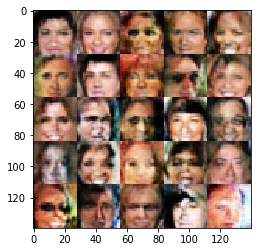

Epoch 1/1... Discriminator Loss: 0.7081... Generator Loss: 1.0921
Epoch 1/1... Discriminator Loss: 0.5080... Generator Loss: 1.9290
Epoch 1/1... Discriminator Loss: 1.1278... Generator Loss: 0.5893
Epoch 1/1... Discriminator Loss: 1.8498... Generator Loss: 0.3059
Epoch 1/1... Discriminator Loss: 0.4897... Generator Loss: 1.3638
Epoch 1/1... Discriminator Loss: 1.0773... Generator Loss: 0.7582
Epoch 1/1... Discriminator Loss: 0.6440... Generator Loss: 1.6177
Epoch 1/1... Discriminator Loss: 0.3190... Generator Loss: 2.3568
Epoch 1/1... Discriminator Loss: 0.4162... Generator Loss: 2.2309
Epoch 1/1... Discriminator Loss: 1.3850... Generator Loss: 3.3181


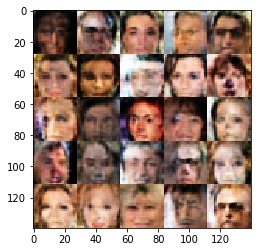

Epoch 1/1... Discriminator Loss: 1.3229... Generator Loss: 0.4632
Epoch 1/1... Discriminator Loss: 0.3033... Generator Loss: 2.8498
Epoch 1/1... Discriminator Loss: 3.1557... Generator Loss: 4.6460
Epoch 1/1... Discriminator Loss: 0.9507... Generator Loss: 0.9648
Epoch 1/1... Discriminator Loss: 0.5758... Generator Loss: 1.5558
Epoch 1/1... Discriminator Loss: 1.0536... Generator Loss: 0.6650
Epoch 1/1... Discriminator Loss: 0.3182... Generator Loss: 2.1965
Epoch 1/1... Discriminator Loss: 0.3801... Generator Loss: 1.9620
Epoch 1/1... Discriminator Loss: 2.0646... Generator Loss: 3.6811
Epoch 1/1... Discriminator Loss: 0.8409... Generator Loss: 0.7583


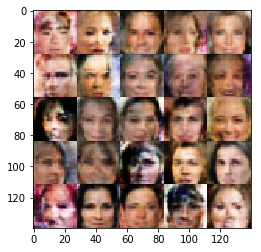

Epoch 1/1... Discriminator Loss: 1.3970... Generator Loss: 3.6651
Epoch 1/1... Discriminator Loss: 0.0957... Generator Loss: 3.2734
Epoch 1/1... Discriminator Loss: 1.1006... Generator Loss: 0.6002
Epoch 1/1... Discriminator Loss: 2.2555... Generator Loss: 6.7753
Epoch 1/1... Discriminator Loss: 0.6810... Generator Loss: 1.1667
Epoch 1/1... Discriminator Loss: 1.0122... Generator Loss: 0.8718
Epoch 1/1... Discriminator Loss: 0.2087... Generator Loss: 2.2029
Epoch 1/1... Discriminator Loss: 2.6054... Generator Loss: 0.1803
Epoch 1/1... Discriminator Loss: 1.6164... Generator Loss: 3.5760
Epoch 1/1... Discriminator Loss: 0.7151... Generator Loss: 1.2911


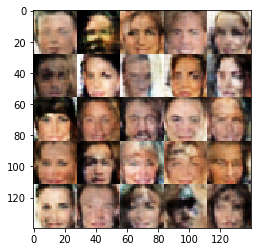

Epoch 1/1... Discriminator Loss: 0.9204... Generator Loss: 0.9456
Epoch 1/1... Discriminator Loss: 0.1682... Generator Loss: 3.0116
Epoch 1/1... Discriminator Loss: 1.4540... Generator Loss: 5.0877
Epoch 1/1... Discriminator Loss: 1.9219... Generator Loss: 0.3350
Epoch 1/1... Discriminator Loss: 0.4907... Generator Loss: 1.4095
Epoch 1/1... Discriminator Loss: 2.6849... Generator Loss: 5.6555
Epoch 1/1... Discriminator Loss: 0.2659... Generator Loss: 2.1855
Epoch 1/1... Discriminator Loss: 0.6850... Generator Loss: 2.6962
Epoch 1/1... Discriminator Loss: 0.6634... Generator Loss: 2.9808
Epoch 1/1... Discriminator Loss: 0.4756... Generator Loss: 1.5949


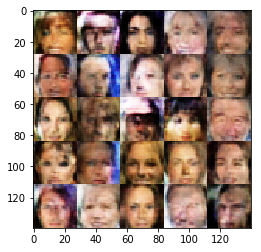

Epoch 1/1... Discriminator Loss: 0.7742... Generator Loss: 0.9906
Epoch 1/1... Discriminator Loss: 1.1556... Generator Loss: 0.5632
Epoch 1/1... Discriminator Loss: 0.4493... Generator Loss: 2.7276
Epoch 1/1... Discriminator Loss: 1.3412... Generator Loss: 5.0112
Epoch 1/1... Discriminator Loss: 0.6873... Generator Loss: 2.8828
Epoch 1/1... Discriminator Loss: 0.2274... Generator Loss: 4.6017
Epoch 1/1... Discriminator Loss: 1.0456... Generator Loss: 3.4107
Epoch 1/1... Discriminator Loss: 0.5343... Generator Loss: 1.4108
Epoch 1/1... Discriminator Loss: 1.2730... Generator Loss: 0.5586
Epoch 1/1... Discriminator Loss: 0.9097... Generator Loss: 0.6962


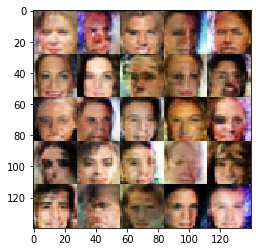

Epoch 1/1... Discriminator Loss: 1.5933... Generator Loss: 0.4164
Epoch 1/1... Discriminator Loss: 0.4476... Generator Loss: 2.8460
Epoch 1/1... Discriminator Loss: 0.2386... Generator Loss: 2.4698
Epoch 1/1... Discriminator Loss: 0.4816... Generator Loss: 1.3823
Epoch 1/1... Discriminator Loss: 3.2245... Generator Loss: 0.1466
Epoch 1/1... Discriminator Loss: 2.1153... Generator Loss: 5.7994
Epoch 1/1... Discriminator Loss: 0.3925... Generator Loss: 3.8578
Epoch 1/1... Discriminator Loss: 0.4856... Generator Loss: 3.2293
Epoch 1/1... Discriminator Loss: 0.8550... Generator Loss: 4.4547
Epoch 1/1... Discriminator Loss: 0.7554... Generator Loss: 0.9046


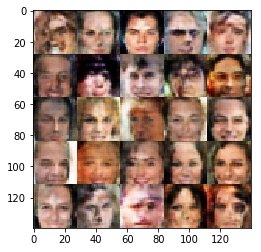

Epoch 1/1... Discriminator Loss: 0.4152... Generator Loss: 2.0017
Epoch 1/1... Discriminator Loss: 0.6989... Generator Loss: 1.0705
Epoch 1/1... Discriminator Loss: 0.5854... Generator Loss: 1.3426
Epoch 1/1... Discriminator Loss: 0.5515... Generator Loss: 1.2701
Epoch 1/1... Discriminator Loss: 1.5848... Generator Loss: 0.4703
Epoch 1/1... Discriminator Loss: 0.1996... Generator Loss: 2.7514
Epoch 1/1... Discriminator Loss: 0.5867... Generator Loss: 2.6571
Epoch 1/1... Discriminator Loss: 0.5097... Generator Loss: 1.3693
Epoch 1/1... Discriminator Loss: 0.1029... Generator Loss: 5.5301
Epoch 1/1... Discriminator Loss: 0.4302... Generator Loss: 3.7495


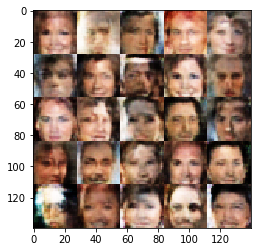

Epoch 1/1... Discriminator Loss: 0.6011... Generator Loss: 3.4788
Epoch 1/1... Discriminator Loss: 0.1841... Generator Loss: 2.5459
Epoch 1/1... Discriminator Loss: 1.4871... Generator Loss: 4.1584
Epoch 1/1... Discriminator Loss: 0.4753... Generator Loss: 4.6440
Epoch 1/1... Discriminator Loss: 1.9577... Generator Loss: 3.8596
Epoch 1/1... Discriminator Loss: 0.2279... Generator Loss: 2.6155
Epoch 1/1... Discriminator Loss: 0.3762... Generator Loss: 3.1869
Epoch 1/1... Discriminator Loss: 1.4349... Generator Loss: 0.4926
Epoch 1/1... Discriminator Loss: 0.4728... Generator Loss: 2.4395
Epoch 1/1... Discriminator Loss: 0.9953... Generator Loss: 0.6841


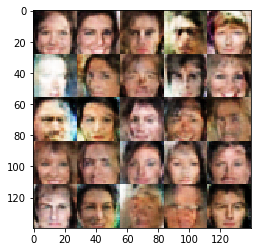

Epoch 1/1... Discriminator Loss: 0.1771... Generator Loss: 4.3979
Epoch 1/1... Discriminator Loss: 0.7193... Generator Loss: 1.6821
Epoch 1/1... Discriminator Loss: 2.3191... Generator Loss: 0.1923
Epoch 1/1... Discriminator Loss: 1.4002... Generator Loss: 0.4301
Epoch 1/1... Discriminator Loss: 0.5255... Generator Loss: 1.3496
Epoch 1/1... Discriminator Loss: 0.2108... Generator Loss: 2.4081
Epoch 1/1... Discriminator Loss: 0.4597... Generator Loss: 1.6296
Epoch 1/1... Discriminator Loss: 0.3483... Generator Loss: 3.1049
Epoch 1/1... Discriminator Loss: 0.5880... Generator Loss: 5.6261
Epoch 1/1... Discriminator Loss: 0.2578... Generator Loss: 1.9267


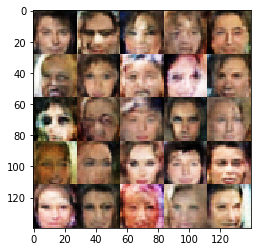

Epoch 1/1... Discriminator Loss: 1.3498... Generator Loss: 0.5021
Epoch 1/1... Discriminator Loss: 0.1570... Generator Loss: 2.8661
Epoch 1/1... Discriminator Loss: 0.3193... Generator Loss: 1.8571
Epoch 1/1... Discriminator Loss: 0.1151... Generator Loss: 4.0860
Epoch 1/1... Discriminator Loss: 0.1328... Generator Loss: 4.3038
Epoch 1/1... Discriminator Loss: 0.1393... Generator Loss: 3.3177
Epoch 1/1... Discriminator Loss: 0.2591... Generator Loss: 2.1827
Epoch 1/1... Discriminator Loss: 0.3412... Generator Loss: 1.8091
Epoch 1/1... Discriminator Loss: 0.8320... Generator Loss: 1.0011
Epoch 1/1... Discriminator Loss: 0.1970... Generator Loss: 3.3673


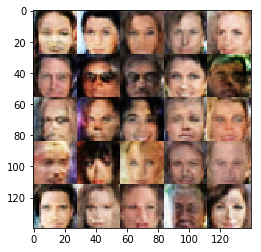

Epoch 1/1... Discriminator Loss: 0.7584... Generator Loss: 5.4054
Epoch 1/1... Discriminator Loss: 0.3656... Generator Loss: 4.7819
Epoch 1/1... Discriminator Loss: 0.4304... Generator Loss: 1.6164
Epoch 1/1... Discriminator Loss: 0.2057... Generator Loss: 3.0169
Epoch 1/1... Discriminator Loss: 0.1513... Generator Loss: 4.0238
Epoch 1/1... Discriminator Loss: 1.3966... Generator Loss: 0.5707


In [13]:
batch_size = 64
z_dim = 100
learning_rate = 0.0003
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.